In [1]:
import sys
import json
import string
import csv
from collections import Counter
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import words
nltk.download('words')
import matplotlib.pyplot as mpl
import pandas as pd
import codecs
import re
import datetime
import emoji
from langdetect import detect, LangDetectException
from datetime import datetime
import numpy as np
import math

import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

from colorama import Fore, Back, Style
import pandas as pd
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nopphasorn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nopphasorn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Nopphasorn\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Nopphasorn\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
C:\Users\Nopphasorn\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Nopphasorn\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pan

## Load 'Youtube' Data

In [2]:
youtube_df = pd.read_csv('cleaned_youtube.csv')
# Display the first few rows of the DataFrame
print(youtube_df.head())

      video_id                channel_id            timestamp  \
0  _6H6oAzWay0  UC-r8XyqbggZobMiNsqgWkDg  2016-06-25 03:30:00   
1  _6H6oAzWay0  UC-r8XyqbggZobMiNsqgWkDg  2016-06-25 03:30:00   
2  _6H6oAzWay0  UC-r8XyqbggZobMiNsqgWkDg  2016-06-25 03:30:00   
3  _6H6oAzWay0  UC-r8XyqbggZobMiNsqgWkDg  2016-06-25 03:30:00   
4  _6H6oAzWay0  UC-r8XyqbggZobMiNsqgWkDg  2016-06-25 03:30:00   

                                             content  like_count  event_id  
0  Jenson Bunny....lol, nichole, i swear when i s...         0.0         1  
1  Please, please come back to Stardew! We would ...         2.0         1  
2                Hoping we get the last two seeasons         1.0         1  
3  the gentle sound of her mouse clicking is so t...         1.0         1  
4  CA just released 1.6!! I hope you??ll get to p...         1.0         1  


In [3]:
print(len(youtube_df))

12154


## Time-Series Analysis: Reviews Over Time

### the Number of Reviews Monthly

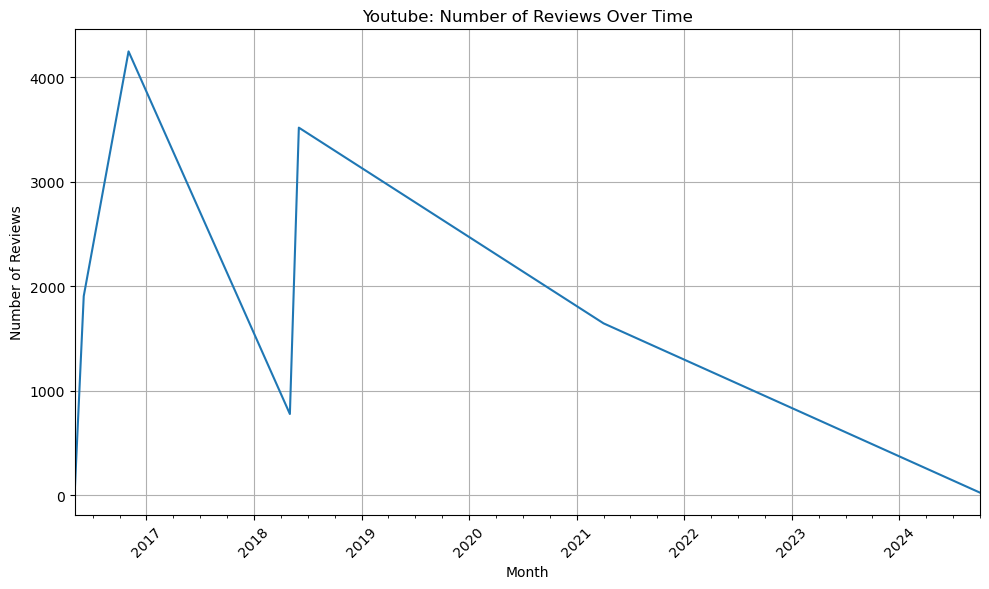

In [4]:
import matplotlib.pyplot as plt

# Convert the 'timestamp_created_converted' to the date format (if not done yet)

youtube_df['date'] = pd.to_datetime(youtube_df['timestamp']).dt.to_period('M')

# Group reviews by date (monthly) and count how many reviews were submitted each month
reviews_per_month = youtube_df.groupby('date').size()

# Plot the number of reviews over time
plt.figure(figsize=(10,6))
reviews_per_month.plot()
plt.title("Youtube: Number of Reviews Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### the Number of Reviews Yearly

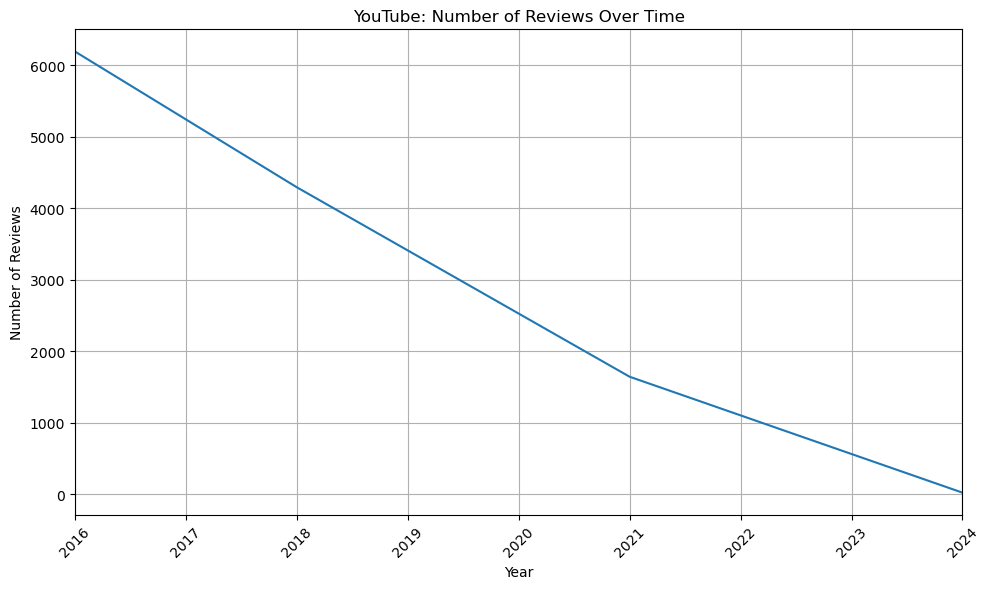

In [5]:

# Convert the 'timestamp_created_converted' to the date format (if not done yet)
youtube_df['date'] = pd.to_datetime(youtube_df['timestamp']).dt.to_period('Y')

# Group reviews by date (monthly) and count how many reviews were submitted each month
reviews_per_month = youtube_df.groupby('date').size()

# Plot the number of reviews over time
plt.figure(figsize=(10,6))
reviews_per_month.plot()
plt.title("YouTube: Number of Reviews Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Data Processing

In [6]:
from nltk.corpus import words
# Load the set of valid English words
valid_words = set(words.words())

# Slang dictionary for replacement
slang_dict = {
    'gg': 'good game',
    'noob': 'newbie',
    'op': 'overpowered',
    'nerf': 'weaken',
    'idk': "i don't know",
    'afk': 'away from keyboard',
    'ftw': 'for the win',
    'smh': 'shaking my head',
    'lol': 'laughing out loud',
}

def replace_slang(text, slang_dict):
    """Replace slang terms in text using the provided slang dictionary."""
    words = text.split()
    replaced_text = ' '.join([slang_dict.get(word.lower(), word) for word in words])
    return replaced_text


def filter_filler_words(tokens):
    """Remove short or meaningless words such as 'wa', 'ha', and words with less than 3 characters."""
    filler_words = {'wa', 'ha', 'uh', 'um'}
    return [token for token in tokens if len(token) > 2 and token not in filler_words]

def processText(text, tokenizer, lemmatizer, stemmer, stopwords, slang_dict):
    """
    Tokenize, lemmatize, and stem the text, removing stopwords, extra words, and invalid/nonsense words.
    """
    # Check if the input text is valid
    if not isinstance(text, str):
        return []
    
    # Remove URLs and special characters
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Step 1: Replace slang using the slang dictionary
    text = replace_slang(text, slang_dict)

    # Tokenise the text
    lTokens = tokenizer.tokenize(text)

    # Custom words to remove
    extra_remove_words = ['game', 'stardew', 'valley', 'video','youtube','dont']

    # Process tokens: lowercase, lemmatize, and filter non-alphabetic tokens
    lTokens = [lemmatizer.lemmatize(token.lower().strip()) for token in lTokens if token.isalpha()]

    # Apply filtering: remove short words, invalid words, and stopwords
    filtered_tokens = [stemmer.stem(token) for token in lTokens 
                       if len(token) > 2  # Filter out short words (less than 3 characters)
                       and token not in stopwords 
                       and token not in extra_remove_words
                       and token in valid_words]  # Only keep valid English words
    
    # Step 5: Remove filler words (like 'wa', 'ha')
    final_tokens = filter_filler_words(filtered_tokens)

    return final_tokens


## Top 30 most frequent words

In [7]:
# number of most frequent terms to display
freqNum = 30

# use the punctuation symbols defined in string.punctuation
lPunct = list(string.punctuation)
# use stopwords from nltk and a few other twitter specific terms like 'rt' (retweet)
lStopwords = nltk.corpus.stopwords.words('english') + lPunct + ['rt', 'via', '...', '…', '"', "'", '`',"’","“","”",".."]
# Initialize the lemmatizer and stemmer
lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()

# our term frequency counter
termFreqCounter = Counter()
# tweet tokeniser to use
tweetTokeniser = nltk.tokenize.TweetTokenizer()

In [8]:
# Loop through each review and process it with both lemmatizer and stemmer

for reviews in youtube_df['content']:
    lTokens = processText(text=reviews, tokenizer=tweetTokeniser, lemmatizer=lemmatizer, stemmer=stemmer, stopwords=lStopwords,slang_dict=slang_dict)
    termFreqCounter.update(lTokens)

# print out most common terms
thirtyfreq_words_reviews = {}
for term, count in termFreqCounter.most_common(freqNum):
    print(term + ': ' + str(count))
    thirtyfreq_words_reviews[term] = count

like: 1428
love: 1403
get: 1380
make: 944
farm: 880
one: 824
day: 794
know: 635
time: 623
watch: 601
thank: 599
give: 584
work: 582
play: 578
much: 550
realli: 533
need: 523
see: 494
year: 491
good: 491
also: 490
first: 478
thing: 439
got: 436
think: 425
fish: 417
would: 416
look: 412
laugh: 409
tri: 399


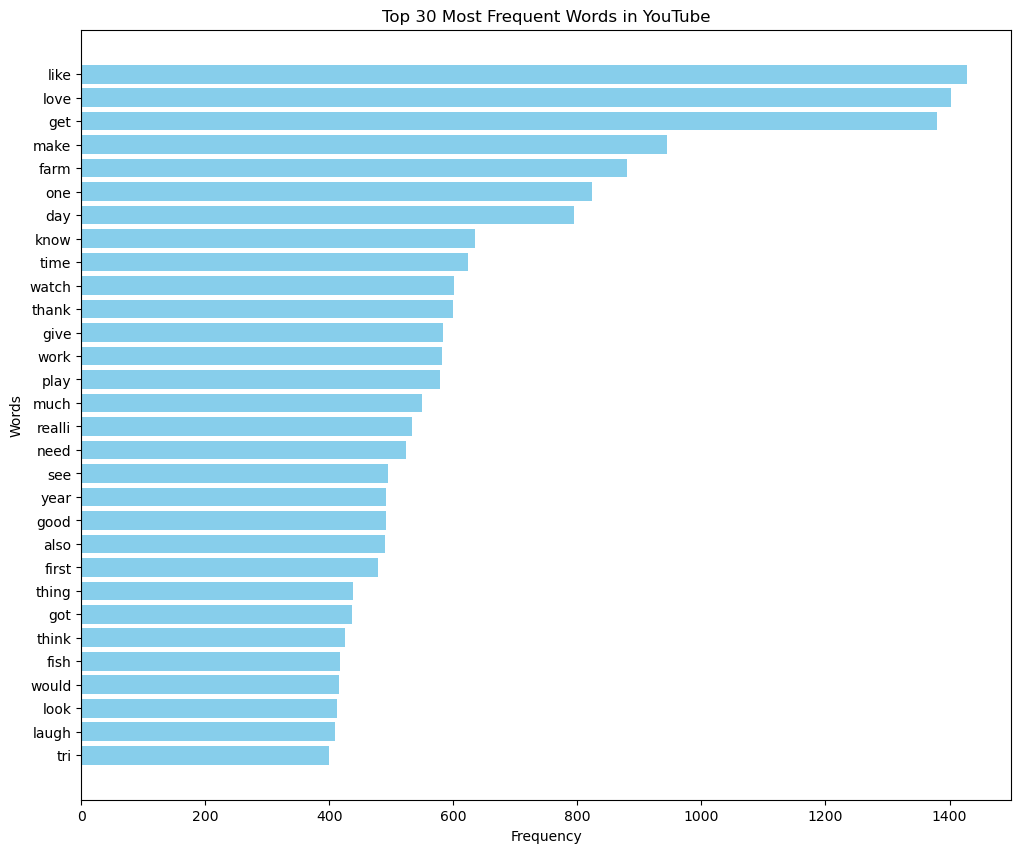

In [9]:
words= list(thirtyfreq_words_reviews.keys())
counts= list(thirtyfreq_words_reviews.values())

plt.figure(figsize=(12,10))
plt.barh(words, counts, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 30 Most Frequent Words in YouTube')
plt.gca().invert_yaxis()  # Invert y-axis to have the most frequent words on top
plt.show()

## Sentiment Analysis

In [10]:
def vaderPrintTokens(lTokens, dSentimentScores):
    """
    Print out the tokens and sentiment score.
    
    @param lTokens: List of tokens to print and colour.
    @dSentimentScores: Dictionary of sentiment from Vader.

    """
    print(*lTokens, sep=', ')
    for cat,score in dSentimentScores.items():
        print('{0}: {1}, '.format(cat, score), end='')
    print()

In [11]:
def vaderSentimentAnalysis(df, bPrint):
    """
    Use Vader lexicons instead of a raw positive and negative word count.

    @param df: DataFrame containing review text and timestamp columns.
    @param bPrint: whether to print the stream of tokens and sentiment.

    @returns: list of posts, in the format of [date, sentiment].
    """

    # Initialize the VADER sentiment analyzer
    sentAnalyser = SentimentIntensityAnalyzer()

    lSentiment = []
    
    # Iterate over each row in the DataFrame
    for idx, row in df.iterrows():
        # Extract the 'review' and 'timestamp_created_converted' for the current row
        postText = row['content']
        postDate = row['timestamp']
        
        # Pre-process the post text
        lTokens = processText(text=postText, tokenizer=tweetTokeniser, lemmatizer=lemmatizer, stemmer=stemmer, stopwords=lStopwords,slang_dict=slang_dict)

        # Compute the sentiment scores using VADER
        dSentimentScores = sentAnalyser.polarity_scores(" ".join(lTokens))

        # Save the date and compound sentiment score (used for time series)
        lSentiment.append([pd.to_datetime(postDate), dSentimentScores['compound']])

        # Print the tokens and sentiment scores if bPrint is True
        if bPrint:
            vaderPrintTokens(lTokens, dSentimentScores)

    return lSentiment


In [12]:
# input file of set of postive words
posWordFile = 'positive-words.txt'
# input file of set of negative words
negWordFile = 'negative-words.txt'

# flag to determine whether to print out tweets and their sentiment
flagPrint = True
# load set of positive words
lPosWords = []
with open(posWordFile, 'r', encoding='utf-8', errors='ignore') as fPos:
    for sLine in fPos:
        lPosWords.append(sLine.strip())

setPosWords = set(lPosWords)


# load set of negative words
lNegWords = []
with codecs.open(negWordFile, 'r', encoding='utf-8', errors='ignore') as fNeg:
    for sLine in fNeg:
        lNegWords.append(sLine.strip())

setNegWords = set(lNegWords)

In [13]:
# compute the sentiment
lSentiment = vaderSentimentAnalysis(youtube_df, flagPrint)

swear, watch, threw, post, race, interview, like, name, sound, like, cartoon, rabbit
neg: 0.079, neu: 0.592, pos: 0.329, compound: 0.5859, 
pleas, pleas, come, back, would, love, see, farm, especi, updat, favorit, even, come, back, truli, love, back
neg: 0.0, neu: 0.641, pos: 0.359, compound: 0.8555, 
get, last, two
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
gentl, sound, mous, tingli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hope, get, play, someday
neg: 0.0, neu: 0.274, pos: 0.726, compound: 0.6486, 
still, watch
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
would, happi, watch, make, settlement
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
post, year, realli, hope, life, well
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.6124, 
imagin, spring, live, life, wake, everi, morn, give, signific, pomegran
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
imagin, taken, famili, made, realiti, hope, love, yeah, spring, hope, see, make, content, futur
neg: 0.0, neu: 0.45, pos: 0.55, compou

think, would, cool, could, like, mayb
neg: 0.0, neu: 0.455, pos: 0.545, compound: 0.5859, 
cant, wait, season
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, racist
neg: 0.8, neu: 0.2, pos: 0.0, compound: -0.6124, 
definit, thank, relax, tingl
neg: 0.0, neu: 0.27, pos: 0.73, compound: 0.6597, 
pleas
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
said, thought, tell
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
watch, like, would, love, see, season
neg: 0.0, neu: 0.374, pos: 0.626, compound: 0.7717, 
love, tour, spring, thank
neg: 0.0, neu: 0.23, pos: 0.77, compound: 0.7717, 
got, today, love, one, realli, sale, today, love, harvest, moon, nostalgia, torn, penni, though, nice, come, relax, hour
neg: 0.069, neu: 0.447, pos: 0.485, compound: 0.9201, 
appreci, pig, make, feel, like, pig, mayb, pig, charact, time
neg: 0.0, neu: 0.783, pos: 0.217, compound: 0.3612, 
made, buy, realli, enjoy
neg: 0.0, neu: 0.484, pos: 0.516, compound: 0.4939, 
white, pillar, look, thing, master, bedroom
ne

love, one, truffl, pig, current, fantast, stream, viewer, hope, also, first, farmer, chosen, one
neg: 0.0, neu: 0.628, pos: 0.372, compound: 0.7964, 
spring, went, stud, hunt, found, got, husband
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, look, forward, see, next, season
neg: 0.0, neu: 0.543, pos: 0.457, compound: 0.6369, 
favorit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
anoth, warm, heart, thank
neg: 0.0, neu: 0.312, pos: 0.688, compound: 0.5267, 
say, thing, last, year
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
dig, farm, sweet, lord, ladi, zoom, play, set, menu
neg: 0.0, neu: 0.565, pos: 0.435, compound: 0.6597, 
corn
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
caught, guard, said, sinc, also, mean, chicken, wonder, name, well, would, interest, actual, name
neg: 0.0, neu: 0.702, pos: 0.298, compound: 0.6249, 
one, that, unlik, harvest, moon, friend, miner, town, girl, version, titl, male, version, shake, head, basic, ident, old, honestli, look, like, pretti, versi

thing, learn, watch, water, kitti, put, path, everywher, creativ, builder
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
comment
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thought, said, crack, pot, instead, crab, pot
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
see, back, childhood, memori, harvest, moon, emul, grew, bit, harvest, moon, friend, miner, town, childhood, memori, buy, sure, sinc, would, much, see, help, make, buy, sinc, realli, good, thank, keep, come
neg: 0.0, neu: 0.657, pos: 0.343, compound: 0.9118, 
admit, copi, block, block
neg: 0.674, neu: 0.116, pos: 0.209, compound: -0.6124, 
scarecrow
neg: 1.0, neu: 0.0, pos: 0.0, compound: -0.2023, 
wow, wonder, farm, tho
neg: 0.0, neu: 0.441, pos: 0.559, compound: 0.5859, 
cat, pedest, around, farm
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
didnt, use, fenc
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
farm, serious, goal, even, know, get
neg: 0.206, neu: 0.794, pos: 0.0, 

use, gold, clock, protect, fenc
neg: 0.0, neu: 0.606, pos: 0.394, compound: 0.3818, 
tho, year, old, cant, rememb, thing, back, miss
neg: 0.186, neu: 0.814, pos: 0.0, compound: -0.1531, 
holi, crap, super, impress, thought, farm, start, get, big, even, close, organ, well, guess, get, back, farm, laugh, loud
neg: 0.089, neu: 0.481, pos: 0.43, compound: 0.872, 
wow, effort
neg: 0.0, neu: 0.208, pos: 0.792, compound: 0.5859, 
cauliflow, make, cauliflow, pickl, home, made
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
post, link, farm, site, show, farm, layout, charact, love, level, skill, cant, rememb, exactli, rememb, ill, edit, repli
neg: 0.122, neu: 0.696, pos: 0.183, compound: 0.34, 
new, sub, like, farm
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
wow, good, method, depend, need, like, winter, prepar, spring, aka, farm
neg: 0.0, neu: 0.465, pos: 0.535, compound: 0.8481, 
speak, bare, hear, say, volum, way
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
holi, crap, look, terribl,

feel, heart, event, special, seen, plan, also, give, player, reason, start, new, farm, pick, differ, even, felt, sorri, poor, opinion, sad, today
neg: 0.222, neu: 0.681, pos: 0.097, compound: -0.5423, 
name, next, dinosaur, thyme
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
name, next, pleas
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
call, next, dinosaur, floret, like, broccoli, floret, cauliflow
neg: 0.0, neu: 0.737, pos: 0.263, compound: 0.3612, 
hay, chest, that, barn
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
earli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
great, seri, bing, also, final, fight, urg, abigail, rout, need, experi, stuff
neg: 0.156, neu: 0.599, pos: 0.246, compound: 0.3612, 
havent, realli, found, anyth, make, love, casual, two, bag
neg: 0.0, neu: 0.538, pos: 0.462, compound: 0.7184, 
know
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
entir, seri, chant, bang, fist, tabl, make, gay, make, gay
neg: 0.0, neu: 1.0,

see
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
life
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
warcraft
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
overwatch, live, live
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
heater, sad
neg: 0.756, neu: 0.244, pos: 0.0, compound: -0.4767, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
legendari, fish, legendari, fish, legend, fish
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
legendari
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
overwatch
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
see
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
prismat, shard
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
know
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
see
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mirror, edg, catalyst
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
stori, mode
neg: 0.0, neu: 1.0, pos: 

everybodi, compar, harvest, moon, actual, like, rune, factori, still, harvest, moon, especi, fight, monster, aspect
neg: 0.144, neu: 0.718, pos: 0.138, compound: -0.0258, 
jimmi, babe, love, liter, harvest, moon, differ, gay, rune, factori, one, favorit, harvest, moon, fight, that
neg: 0.125, neu: 0.673, pos: 0.202, compound: 0.3818, 
entir, convinc, best, person, world, weird, feel, like, relat, yet, hate
neg: 0.283, neu: 0.366, pos: 0.351, compound: 0.3182, 
begin, jimmi, love, doesnt, halfway, god, pictur, frame
neg: 0.151, neu: 0.499, pos: 0.35, compound: 0.5245, 
damn, jimmi, thirsti
neg: 0.574, neu: 0.426, pos: 0.0, compound: -0.4019, 
look, like, treasur, planet
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
get, jimmi, still, huge, fan, mayb, lookout, first, review, new, channel, mine, watch, whole, lot, hidden, block, recent, person, like, littl, bit, normal, boot
neg: 0.097, neu: 0.667, pos: 0.237, compound: 0.4939, 
make, like, summer, resolut, summer, keep, fall, one,

jimmi, gay
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
well, ruin, grandfath, farm
neg: 0.481, neu: 0.253, pos: 0.266, compound: -0.4019, 
like, realli
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
doe, anyon, think, gay
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
bitch, abigail
neg: 0.792, neu: 0.208, pos: 0.0, compound: -0.5859, 
crusti, best, log, horizon, charact
neg: 0.0, neu: 0.488, pos: 0.512, compound: 0.6369, 
god, perfectli, experi, persona
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.2732, 
found, guy, love
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 
bit, late, happi, canada, day
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
went, full, almost
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, gay
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
honestli, favorit, bit, jimmi, tri, get
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
still, better, love, stori, twilight
neg: 0.0, neu: 0.297, pos: 0.703, compound: 0.7964, 
jimmi, someth
neg: 0.0, neu: 1.

grandpa, basic, shove, burden, farm, life, face, thought, free, burden, modern, life, life, free, burden, naiv, fool, burden, life
neg: 0.438, neu: 0.363, pos: 0.199, compound: -0.7845, 
curiou, gay, judgment, wonder
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
doe, mean, jimmi, like
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
great, think, said, love, overal, attitud, like, sure, call, like, care, feel, anyway, love
neg: 0.0, neu: 0.233, pos: 0.767, compound: 0.9719, 
that, cool
neg: 0.0, neu: 0.303, pos: 0.697, compound: 0.3182, 
shield, thirst, best, line, amaz
neg: 0.0, neu: 0.488, pos: 0.512, compound: 0.6369, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
jimmi, deviou, man, start, forget, ador, bam, asid, realli, entertain, away
neg: 0.144, neu: 0.682, pos: 0.174, compound: 0.1027, 
second, thought, subtl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
life, better, watch, mojo
neg: 0.0, neu: 0.508, pos: 0.492, compound: 0.4404, 
hit, jimmi, gay
neg: 0.0, neu: 1.0, pos:

honestli, favorit, come, gay, make, feel, bad, dad, got, cancer, ago, watch, alway, made, feel, better, see, one, today, realli, lot, may, existenti, dread, persuad, pay, rad
neg: 0.331, neu: 0.591, pos: 0.078, compound: -0.8555, 
back, jimmi, wasnt, funni, horribl, time
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hey, jimmi, love, even, watch, recent, day, tell, amaz, day, well, watch, long, alreadi, year, marri, sam
neg: 0.0, neu: 0.704, pos: 0.296, compound: 0.743, 
glad, back, jimmi, wait, expectantli, new, content, great, job, look, forward, next, episod, alreadi
neg: 0.0, neu: 0.628, pos: 0.372, compound: 0.7964, 
god, love, jimmi, cute, voic, like, string, orchestra, ear
neg: 0.0, neu: 0.298, pos: 0.702, compound: 0.8957, 
jimmi, pick, good, piec, bless
neg: 0.0, neu: 0.345, pos: 0.655, compound: 0.6908, 
what, wrong, nose, kink, shame
neg: 0.674, neu: 0.326, pos: 0.0, compound: -0.7351, 
favorit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
time
neg: 0.0, neu: 1.0, pos: 0.0, 

jimmi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
holi, crap, forgot, even
neg: 0.464, neu: 0.536, pos: 0.0, compound: -0.3818, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
pleas, put, pictur, background
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
exceedingli, happi, youv, work
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
moment, charact, taller, everyon, els
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
pick, good, job
neg: 0.0, neu: 0.408, pos: 0.592, compound: 0.4404, 
watch, transform, sassi, gay, black, man, quit, ride
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
glad, came
neg: 0.0, neu: 0.25, pos: 0.75, compound: 0.4588, 
choic, true
neg: 0.0, neu: 0.263, pos: 0.737, compound: 0.4215, 
marri, someon, one, best, part, though, like, fire, emblem
neg: 0.159, neu: 0.397, pos: 0.444, compound: 0.6486, 
awesom, jimmi, wait, realli, worth
neg: 0.0, neu: 0.678, pos: 0.322, compound: 0.2263, 
watch, one, day, life, complet
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
jimmi, fat


neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
pleas, exclus, pleas, come
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
harvest, moon
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
final, happi, stop, wait, consol, version, alreadi, hour, absolut, fantast, much, charm, soul, easili, top, year
neg: 0.112, neu: 0.66, pos: 0.228, compound: 0.3182, 
peopl, keep, also, come, extra, market, right, that, say
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
put
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
think, look, thing, know, start, know, want, start, scratch, like, laugh, loud
neg: 0.0, neu: 0.549, pos: 0.451, compound: 0.7506, 
dang
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cant, wait, see
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
anoth, mine, craft
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
suppos, come, year, wonder, bought, exclus, right
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
need
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.

wow, came, way, cannot, wait
neg: 0.0, neu: 0.513, pos: 0.487, compound: 0.5859, 
soon, date, great, though
neg: 0.0, neu: 0.423, pos: 0.577, compound: 0.6249, 
thank, creator, peac, thank, head
neg: 0.0, neu: 0.375, pos: 0.625, compound: 0.6124, 
realli, wish, part, two
neg: 0.0, neu: 0.526, pos: 0.474, compound: 0.4019, 
packag, hit, axe
neg: 0.412, neu: 0.588, pos: 0.0, compound: -0.1027, 
put, hat, hors
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sorri, doubl, comment, season, load, older, save, charact, around, raccoon, appar, reason, good, day, run, inventori, space, probabl, deposit, farm
neg: 0.0, neu: 0.747, pos: 0.253, compound: 0.7269, 
read, never, bit, sad
neg: 0.0, neu: 0.54, pos: 0.46, compound: 0.3724, 
coffe, one, tast
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
shadow
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
eat, cake, right, joke
neg: 0.0, neu: 0.577, pos: 0.423, compound: 0.296, 
whole, concept, golden, hurt, brain, littl, especi, upgrad, iron
neg: 0.298, n

made, million, first, year, without, farm, fish, even, parsnip, mine, make, materi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mine, broke, didnt, produc, pumpkin
neg: 0.412, neu: 0.588, pos: 0.0, compound: -0.4215, 
festiv, saw, sooner
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
way, get, much, one, day
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
doe, work, switch
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cant
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
doe, work, consol
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
work
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
tri, know, work
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
throw, pumpkin, get, million, gold
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
unfortun, recent, updat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
still, work
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
pretti, sure, pumpkin, suppos, work, like, pretti, sure
neg: 0.0, neu: 0.413, pos: 0.587, compound: 0.7269, 
youv, definit, great, job, tip, tr

sweet, love, babi, brilliant, idea, especi, anim, food, final, enough, batteri, put, toy, make, diamond, machin
neg: 0.0, neu: 0.472, pos: 0.528, compound: 0.9246, 
shock, idea
neg: 0.722, neu: 0.278, pos: 0.0, compound: -0.3818, 
nice, idea
neg: 0.0, neu: 0.263, pos: 0.737, compound: 0.4215, 
sprite, exist, time, lot, knowledg, like, turtl
neg: 0.0, neu: 0.706, pos: 0.294, compound: 0.3612, 
cant, help, hurt
neg: 0.374, neu: 0.166, pos: 0.46, compound: 0.1326, 
liter, cri, like, never, get, better, hate, written, never, see, much, peopl, around, love, realli, hard, see, need, break
neg: 0.138, neu: 0.509, pos: 0.353, compound: 0.784, 
decis, know
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
still, love
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
alway, one, even, bother, graduat, high, school, life, quickli, brought, exact, low, understand, everyth
neg: 0.273, neu: 0.727, pos: 0.0, compound: -0.5423, 
one, song, hear, dine, room, sunni, day
neg: 0.0, neu: 1.0, pos: 0.0, comp

cant, stop, listen, realli, love, charact, love, song, much
neg: 0.0, neu: 0.368, pos: 0.632, compound: 0.8831, 
relat, charact, thing, say, straight, subconsci, theme, realli, highlight, hopeless, loneli, sad, love, much, ill, protect, cost
neg: 0.297, neu: 0.333, pos: 0.37, compound: 0.296, 
song, could, find
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
theme, liter, rip, heart, apart
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
simpl, farm, unbeliev, realist, likabl, charact, mani, issu, dare, touch, like, troubl
neg: 0.0, neu: 0.815, pos: 0.185, compound: 0.3612, 
need, sheet, music
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
aboard, pure, poor, want, give, love, earth
neg: 0.244, neu: 0.236, pos: 0.52, compound: 0.3612, 
what, name, song, theme
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cant, marri, spous
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
entir, song, relat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank, much
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.36

happi, watch, guy, play, togeth, watch, guy, play, way, good, job, subscrib
neg: 0.0, neu: 0.539, pos: 0.461, compound: 0.7717, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
know, like, press, dislik, move, pleas, thank
neg: 0.0, neu: 0.5, pos: 0.5, compound: 0.6124, 
price, wonder, could
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
person
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
happi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
voic, act, though
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
bad, never, seen, anyth
neg: 0.538, neu: 0.462, pos: 0.0, compound: -0.5423, 
price, much, watch, subscrib
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wonder, time, day, seri, get
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
back, old, one, back, stump, branch
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sweet, love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.802, 
price, first, curious, strang
neg: 0.0, neu: 0.566, pos: 0.434, compound: 0.3182, 
tri, date
neg: 0.0, neu: 1.0, pos: 0.0, 

skill, give, gather, iridium, qualiti, work, truffl, pick, truffl, get, also, pig, find, unlimit, amount, truffl, time, find, one, roll, made, low, enough, low, find, anoth, anoth, anoth, anoth, statist, infinit, realist, stop, find, around
neg: 0.167, neu: 0.833, pos: 0.0, compound: -0.6597, 
caboos
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
insan, realli, neat, crazi
neg: 0.0, neu: 0.5, pos: 0.5, compound: 0.4588, 
talk, silo, twice, mistak
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
look, like, job
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
chicken, coop, money, maker, honey, know, idea, make, happen, liter, idea, profit, either, though
neg: 0.0, neu: 0.818, pos: 0.182, compound: 0.4404, 
bacon, wast, dig, mushroom, like, lot, work, return, month, get, set, almost, month, break, even, point, arent, realli, money
neg: 0.0, neu: 0.878, pos: 0.122, compound: 0.3612, 
get, rid, grass, factori, feed, pig, could, make, billion
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
g

real, need, worri, new, version, like, add, youv, stuff, realli, recommend, delux, everyth, get, qualiti, produc, either, way, man, sure, like, talk, anim, welsh, make, wish, simpl
neg: 0.0, neu: 0.638, pos: 0.362, compound: 0.8885, 
display, legendari, fish, seen, anoth
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
way, legendari, fish, get, one, far, wait, winter, tri, hand, one, anoth, great, episod, alway
neg: 0.0, neu: 0.64, pos: 0.36, compound: 0.8074, 
expand, farm, near, winter, come, come, year, winter, ill, hope, grow, farm, sinc, rather, small, wish, slime, hutch, interest, featur, add, breed, that, know, purpl, slime, drop, iridium, someth, much
neg: 0.123, neu: 0.603, pos: 0.274, compound: 0.7184, 
museum, vanilla, featur
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hey, found, channel, day, ago, bing, watch, amaz, content, find, voic
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
room, spilt, beer, perpetu, rug, room, like
neg: 0.0, neu: 0.706, pos: 0.294, compound: 0.361

ball
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
doe, still, work, anyon, know
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
longer, work
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
switch
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
still, work
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
holi, work
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
longer, work, switch
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
fix
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
work, bundl, mart
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
tri, work, unless, wrong, pleas, let, know
neg: 0.341, neu: 0.659, pos: 0.0, compound: -0.4767, 
doesnt, work, rip
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
got, prismat, shard, slime, good, know
neg: 0.0, neu: 0.633, pos: 0.367, compound: 0.4404, 
work, android
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
work
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
spent, money, know, fix
neg: 0.0, neu: 1.0, pos: 0.0, 

ancient, seed, day, current, year, still, havent, found, singl, one, item, miss, crop, collect
neg: 0.11, neu: 0.89, pos: 0.0, compound: -0.1531, 
get
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
coffe, bean
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
watch, begin, actual, took, gold, parsnip, give, pam, commun, center, requir, gold, parsnip
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
everyon, get, first, batch, new, seed, day
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
saloon
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
come, trailer, doesnt, rectangular, layout, insid
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
close, crow, almost, eat, ancient, seed
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
somewhat, monoton, comment, amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
laugh, loud, cant, believ, didnt, wait, day, plant, rare, ancient, seed, protect, scarecrow, laugh, loud
neg: 0.08, neu: 0.487, pos: 0.434, compound: 

get, tell, everyth, charact, mous
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
dog, bowl, didnt, give, anyth, useless, water
neg: 0.0, neu: 0.72, pos: 0.28, compound: 0.3252, 
need, watch, rerun, get, cook
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
know, someon, yet, realli, good, idea, check, fortun, everyday, especi, mine, geod, process, geod, day, luck, poor, like, get, thing, stone, clay, wherea, luck, good, like, get, preciou, stone, artifact, also, found, better, process, lot, geod, rather, anoth, thing, pet, dog, dog, happi, doe, factor, kind, score, get, grandfath, return, third, year, someth, cant, check, better, side
neg: 0.041, neu: 0.618, pos: 0.342, compound: 0.9678, 
saloon, basic, buy, everyon, beer, like, except, like, salad, also, buy, saloon
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.6124, 
sure, check, commun, bundl, menu, somewher, run, everi, time, see, need
neg: 0.0, neu: 0.813, pos: 0.187, compound: 0.3182, 
place, chest, around, town, conveni, access, goo

peopl, like, good, tell, everi, secret, tell, everi, singl, secret, peopl, talk, pleas, everyon, peopl, secret, everyon, stair, peopl, told, everi, secret
neg: 0.0, neu: 0.787, pos: 0.213, compound: 0.6597, 
littl, girl, spoke, suddenli, wood, unless, day, near, type, place, run, prayer, heart, would, feel, bad, would, tri, help, two, sadli, like, due, god, damn, guilti, idiot, self
neg: 0.245, neu: 0.567, pos: 0.188, compound: -0.4939, 
amaz, mani, time, look, walk, past, exact, moment, without, time, past, work, time, past, saloon, clock, night, fish, buzzer, might, leav, bar
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
met, maru, interest, meet, subtext, pleas, marri, daughter, get, life
neg: 0.0, neu: 0.75, pos: 0.25, compound: 0.4588, 
watch, tri, watch, whole, seri, edit, want, say, thank, like, easili, comment, edit, watch, edit, peopl, edit, still, got, peopl, watch
neg: 0.0, neu: 0.741, pos: 0.259, compound: 0.6486, 
bing, watch, everi, singl, time, watch, voic, end, make, fa

get, coop, use, everyon, except, carolin, like, also, rememb, birthday, give, lot, friendship, point
neg: 0.0, neu: 0.69, pos: 0.31, compound: 0.6597, 
give, gift, see, like, commun, center, would, fun, hard, fun, forget, marri, someon
neg: 0.148, neu: 0.314, pos: 0.538, compound: 0.8658, 
singl, girl, like, old, man, love, leek, like, everyth, someth, fish, black, guy, like, thing, investig, pam, like, everyth, use, beverag, beer, pale, ale, wine, like, food, clint, like, everyth, connect, mine, like, ingot, like, lot, natur, like, gem, stuff, make, cloth, desert, girl, sandi, love, flower, rest, peopl, know, check, rest
neg: 0.0, neu: 0.57, pos: 0.43, compound: 0.9816, 
mart, work, last, guy, find, stock, shelf, use, help, use, rememb, charact, gift, make, easier
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.8126, 
hard, everyon, talk, whoever, conveni, keep, dialogu, flower, woman, that, cheap, easi, gift, stock, pile, crop, run, errand, like, love, parsnip
neg: 0.05, neu: 0.607, po

sure, time, limit, run, tri, achiev, first, year, achiev, want, get
neg: 0.0, neu: 0.714, pos: 0.286, compound: 0.3818, 
check, cook, channel, recip, repeat, day, week, differ, new, recip, may, bug
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
dive, find, food, trash, recycl, coal, need, food, energi, mine
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
like, typo
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
recal, realli, smart, laugh, loud
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.743, 
need, run
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
marri, give, gift, like, everyday
neg: 0.0, neu: 0.357, pos: 0.643, compound: 0.6597, 
social, stuff, villag, highli, recommend, everybodi, make, list, whichev, item, easi, collect, bulk, multipl, peopl, like, exampl, beer, everyon, bar, great, sinc, lot, peopl, almost, everyon, least, like, beer, salad, also, bought, sinc, love, plan, short, rout, take, way, activ, town, like, sinc, give, gift, get, everyon, town, rel, easi, throughout

last, person, need, meet, life, usual, catch, leav, earli, morn, either, work, mart, saloon, wizard, doesnt, actual, count, introduct, quest, tower, wont, open, commun, center, open, letter, tell, see, guy, love, leek
neg: 0.0, neu: 0.881, pos: 0.119, compound: 0.6369, 
watch, everi, day, get, cook, recip
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
probabl, know, alreadi, yoi, check, villag, day, schedul, like
neg: 0.0, neu: 0.762, pos: 0.238, compound: 0.3612, 
slot, mean, right
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
get, money, buy, catalogu, weird, like, wallpap, realli, worth, money, get, everyon, heart, realli, fast
neg: 0.094, neu: 0.663, pos: 0.243, compound: 0.4019, 
man, realli, love
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 
good, luck, buy, bean, starter, least, cauliflow, get, grow, need, one, spring, crop, bundl, day, grow, plu, get, cauliflow, quest, late, month, alway, come, youv, sold, enough, time, grow, first, year, potato, actual, good, sourc, earl

happi, birthday
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
goat, chees, weird, tast, opinion, definit, done, right
neg: 0.195, neu: 0.805, pos: 0.0, compound: -0.1779, 
build, certain, thing, insid, like, chest, thing, keep, thing, organ
neg: 0.0, neu: 0.635, pos: 0.365, compound: 0.5574, 
lewi, get, chees, present, stori, like
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.3612, 
goat, chees, far, salti, know, horribl, person
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
goat, chees, definit, better, cottag, chees
neg: 0.0, neu: 0.633, pos: 0.367, compound: 0.4404, 
happi, birthday, favorit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
said, secret, friend, perfect
neg: 0.0, neu: 0.225, pos: 0.775, compound: 0.7845, 
still, episod, short
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
goat, chees
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
might, want, plant, wilder, back, corner, farm, way, alway, lot, wood, nearbi, also, didnt, care, anim, feast, day, fed, day
neg: 0.12, neu: 0.82

one, pig, said, name, look, thin, mean, havent, eaten, auto, feeder, work, enough, hay, slot, would, full, hay, sure, auto, feeder, mess
neg: 0.101, neu: 0.806, pos: 0.093, compound: -0.0516, 
close, door, everi, night, pet, morn, let, eat, hay, insid, rais, want, mood, good, certain, level, tri, make, larg, version, good, wont, produc, anyth, around, pig, level, make, easi, everi, day, truffl
neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.802, 
would, suggest, tri, follow, close, barn, door, everyday, anim, first, thing, morn, open, barn, door, easier, instead, confin, check, silo, daili, think, raini, day, silo, empti, auto, feeder, put, last, piec, hay, left, thought, pig, alreadi, ate, believ, bit, later, mean, realli, enough, feed, pig, coupl, barn, anim, heart, never, grumpi, although, probabl, time, effici, wait, close, door, night
neg: 0.0, neu: 0.954, pos: 0.046, compound: 0.4215, 
hut, doesnt, even, harvest, crop, like, say, doe, man, thing, stupid
neg: 0.228, neu: 0.604, pos:

total, grow, tree, grass, also, remov, bush, axe
neg: 0.167, neu: 0.833, pos: 0.0, compound: -0.1027, 
thank, content, awesom
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
put, slingshot, chest, put, path, destroy, chest, stuff
neg: 0.333, neu: 0.667, pos: 0.0, compound: -0.5423, 
think, sell, slingshot, guess, way, get, back, ever, accident, sell, though, know, anyon, slingshot, hammer, sword
neg: 0.171, neu: 0.829, pos: 0.0, compound: -0.4767, 
play, straight, quest, relationship, whole, deal, way, one, record, easier, manag, possibl, also, live, record, possibl, voic, thought, commentari, would, hilari
neg: 0.0, neu: 0.717, pos: 0.283, compound: 0.7269, 
rabbit, produc, wool, well, forget, door, open, problem, day, sure, unhappi, door, open
neg: 0.256, neu: 0.5, pos: 0.244, compound: -0.0516, 
walk, barn, food, feeder, mean, theyr, fed, bug, moment, manual, feed, bugger
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
pig, unhappi, theyr, fed, hay, tray, eat, end, day
neg: 0.0, 

els, watch
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
laugh, hard, thought, instant, build
neg: 0.175, neu: 0.375, pos: 0.45, compound: 0.4939, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
bear, warp, think
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
stop, eat, snap
neg: 0.524, neu: 0.476, pos: 0.0, compound: -0.296, 
clue, shrine, thing
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
watch
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
lunar
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
play, axe, know, give, back, got, money
neg: 0.159, neu: 0.568, pos: 0.273, compound: 0.25, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
key, ancient, templ
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
one, sold, parsnip
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
shrine, kind, portal
neg: 0.0, neu: 0.37, pos: 0.63, compound: 0.5267, 
gosh, liter, favorit, time
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sell, sell, sell
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
one, told, funni, bear,

abigail, name
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
like, comment
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
love, know, ask, valentin, also, ship
neg: 0.0, neu: 0.543, pos: 0.457, compound: 0.6369, 
what
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
pleb
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
realiz, said, sell, money, food
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
big, year, never, saw, thing
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sell, money, food
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
rainbow
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
said, sell, money, food, instead, sell, food, money
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
anyon, catch, mark, sell, money, food, eat, food, farm, note, great, grammar, think, way, around, like, sell, food, money
neg: 0.0, neu: 0.72, pos: 0.28, compound: 0.765, 
imposs, get, level, brother, good, level
neg: 0.0, neu: 0.633, pos: 0.367, compound: 0.4404,

bad, news, everybodi, watch, got, star, dew
neg: 0.368, neu: 0.632, pos: 0.0, compound: -0.5423, 
voic, crack, mani, time, laugh, loud
neg: 0.0, neu: 0.581, pos: 0.419, compound: 0.5574, 
tri, get, cant
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
rose, red, violet, blue, rainbow, agre, bring, seri
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
said, get, food, money
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
play, pleas
neg: 0.0, neu: 0.294, pos: 0.706, compound: 0.34, 
hear, say, doctor, strang, like
neg: 0.0, neu: 0.615, pos: 0.385, compound: 0.3612, 
tri, tilt, worm, ground, see
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
leav, stump, tree, grow, back, like, see, wont
neg: 0.0, neu: 0.737, pos: 0.263, compound: 0.3612, 
late, year, know, everyth
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hey, turn, vampir, real
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
give, play, crew, friend, crew
neg: 0.0, neu: 0.349, pos: 0.651, compound: 0.6808, 
give, strain
neg: 0.545, neu: 0.455

play, studio, make, self
neg: 0.0, neu: 0.556, pos: 0.444, compound: 0.34, 
love, much
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
treasur, food, swallow, whole
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
live, well, mayb, next, thank
neg: 0.0, neu: 0.395, pos: 0.605, compound: 0.5574, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
birthday
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
name
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
play, say, murder, mysteri
neg: 0.516, neu: 0.22, pos: 0.264, compound: -0.5106, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
rainbow, guy
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
join, number, one, fan
neg: 0.0, neu: 0.147, pos: 0.853, compound: 0.5859, 
hey, secret, bee, swarm, simul, shout, want, see
neg: 0.0, neu: 0.843, pos: 0.157, compound: 0.0772, 
favorit, sorri, comment
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
let, room
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
pl

man, friend, call, strang
neg: 0.0, neu: 0.484, pos: 0.516, compound: 0.4939, 
play, granni, basic
neg: 0.0, neu: 0.455, pos: 0.545, compound: 0.34, 
rose, red, violet, blue, best, like, agre
neg: 0.0, neu: 0.427, pos: 0.573, compound: 0.7717, 
tri, play, hand, simul, steam
neg: 0.0, neu: 0.349, pos: 0.651, compound: 0.6808, 
sorri, want, watch, like, want, human, fall, flat, said, everi, play, someth, new, sorri
neg: 0.0, neu: 0.571, pos: 0.429, compound: 0.6705, 
pun, mine, edit, start, like, hungri, bake, cake, tonight, let, watch, let, paint, rainbow
neg: 0.0, neu: 0.839, pos: 0.161, compound: 0.3612, 
ship, lunar
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
play, basic
neg: 0.0, neu: 0.294, pos: 0.706, compound: 0.34, 
eat, everyon
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, much, keep, great, work, work, even, tho, realli, sad, watch, make, happi, whole, comment
neg: 0.132, neu: 0.513, pos: 0.355, compound: 0.7351, 
sell, food, money, eat, anyth
neg: 0.0, neu: 1.0, pos: 

new, mayb, routin
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
make, babi, high
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
play
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.34, 
fun, watch, keep, watch, republ
neg: 0.0, neu: 0.548, pos: 0.452, compound: 0.5106, 
alway, come, alway, earli, like, sorri, bad
neg: 0.318, neu: 0.455, pos: 0.227, compound: -0.25, 
wait, even, sam
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thought, turn, episod, season
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
craft
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
opposit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
make, seri, crazi, craft, pleas
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
laugh, loud, best, ever, famili, friendli, funni, well, know, good, thing, would, say, best
neg: 0.0, neu: 0.346, pos: 0.654, compound: 0.9517, 
join, parti
neg: 0.0, neu: 0.312, pos: 0.688, compound: 0.296, 
never, even, play, play, gang, beast
neg: 0.504, neu: 0.496, pos: 0.0, compound: -0.4717, 
dream, dog
neg: 

alec, cheat
neg: 0.75, neu: 0.25, pos: 0.0, compound: -0.4588, 
love, show, face
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 
potato, hous, love, stay, potato
neg: 0.0, neu: 0.488, pos: 0.512, compound: 0.6369, 
use, seed, make, field, snack
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
made, volcano, detail, fondant
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sell, geod, give, use, item
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
friend, best, friend, friend
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.93, 
guy, anoth, craft, love, guy, one, favorit
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.6369, 
coop, coop, coop
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
rememb, famili, went, univers, studio, well, what, realli, realli, play, way, subscrib, like, turn, notif
neg: 0.0, neu: 0.632, pos: 0.368, compound: 0.7184, 
pleas, high, school, love, much
neg: 0.0, neu: 0.488, pos: 0.512, compound: 0.6369, 
new, sub, alreadi, love
neg: 0.0, neu: 0.417, pos: 0.583, compound: 0.6369

eat, food, farm, life, eat, farm, miss, someth, cant, farmer, without, crew, buy, everi, watch, hope, like, see, next
neg: 0.07, neu: 0.696, pos: 0.235, compound: 0.5859, 
cabin, open, door, sorri, friend, penni, notic, anyth, like, comment
neg: 0.0, neu: 0.584, pos: 0.416, compound: 0.6908, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
sub, channel, best, make, frown, flip, upsid
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.6369, 
get, home, school, run, comput, watch, love, fam
neg: 0.0, neu: 0.625, pos: 0.375, compound: 0.6369, 
come, think, havent
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
keep, get, mix, money
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
stay, night, watch, tho
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
eat, sell, food, eat, bye
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
live
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
famili
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
get, bed, hous, anyon, agre
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0,

happi, tomorrow, danc, school, end, school, day, ill, know, anoth, countri, blah, blah, wear, rainbow, color, laugh, loud, pink, white, happi, problem, need, school, realli, earli, make, know, danc, parti, call, parti, school, parti, school, need, night, sleep, love, much
neg: 0.166, neu: 0.679, pos: 0.156, compound: 0.3612, 
want, travel, far, littl, potato
neg: 0.0, neu: 0.755, pos: 0.245, compound: 0.0772, 
love, pleas, make, seri
neg: 0.0, neu: 0.417, pos: 0.583, compound: 0.6369, 
cant, believ, guy, would, get, awesom, player
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sell, money, food, sell, money
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
schedul, random
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sam, wait, even, set, hello, lunar, insult, dare, get, trigger, start, swing, axe, get, get, like, potato, make, happi
neg: 0.203, neu: 0.69, pos: 0.108, compound: -0.296, 
eat, lunar, live, life, lunar
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
feel, water, old, friend
neg:

mine, mime, funni
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
laugh, loud, ate, front
neg: 0.0, neu: 0.455, pos: 0.545, compound: 0.5574, 
earli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
watch
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
earli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
tomorrow
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, laugh, loud, love
neg: 0.0, neu: 0.077, pos: 0.923, compound: 0.9186, 
amaz, love
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
pleas, play, build, boat, treasur
neg: 0.0, neu: 0.625, pos: 0.375, compound: 0.34, 
sam, even, set, even, brain
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
miss, high, school, bring, back, bring, back
neg: 0.211, neu: 0.789, pos: 0.0, compound: -0.1531, 
rose, red, violet, blue, best, know, sorri, cant, make, thing, rhyme
neg: 0.0, neu: 0.704, pos: 0.296, compound: 0.6369, 
said, sell, money, food
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sister, watch, channel, everyday
neg: 0.0, neu: 1.0, pos:

wait, post, new
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
play, human, fall, flat
neg: 0.0, neu: 0.556, pos: 0.444, compound: 0.34, 
tooth, came, yesterday, almost, year, old, birthday, actual, watch, lot, year, hope, get, shout, next, love
neg: 0.0, neu: 0.664, pos: 0.336, compound: 0.7964, 
hey, miss, seri, bet, peopl
neg: 0.286, neu: 0.714, pos: 0.0, compound: -0.1531, 
love, keep, good, work
neg: 0.0, neu: 0.22, pos: 0.78, compound: 0.7964, 
best
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
mine
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
dare, name, cri
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
fun, lie
neg: 0.0, neu: 0.233, pos: 0.767, compound: 0.5106, 
phone, that, hous
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
standard, high
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
famili
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
awak, late, wow
neg: 0.0, neu: 0.345, pos: 0.655, compound: 0.5859, 
robin, want, instant, b

play, royal, high, super, new, updat, carriag, see, new, royal, high
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.743, 
final, late
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hay, post, love, see, know, ben, crew
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.6369, 
came, minut, late, sinc, watch, anoth, anoth
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
good, job, amaz, keep, love, guy, want, meet, bad, cant, live
neg: 0.185, neu: 0.37, pos: 0.444, compound: 0.5994, 
love, watch, sinc, begin
neg: 0.0, neu: 0.417, pos: 0.583, compound: 0.6369, 
earli, potato, squad
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
earli, love, sorri, wrong
neg: 0.333, neu: 0.215, pos: 0.452, compound: 0.2732, 
mayb, earli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
earli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sell, food, money, eat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
play, next, time, pleas, pleas, pleas, pleas, pleas, pleas, pleas, pleas, pleas, pleas, pleas, pleas, play, happi, sin

famili, pleas, pin, comment, way, give, channel
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
today, day, summer, break
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hair, sinc
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
view, comment, that
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wait, set, gasp, need, school
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
earli, didnt, even, watch, hole, yet
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
saw, play, dream, cri, dream, dream, know, watch, stop, cri
neg: 0.141, neu: 0.321, pos: 0.538, compound: 0.6369, 
dare
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
like, ever, peopl, hold, carrot, like, comment, pleb
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.6124, 
earli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
late, wait, post, sec, ago, laugh, loud
neg: 0.0, neu: 0.625, pos: 0.375, compound: 0.5574, 
earli, say, drew
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
view
neg: 0.0, neu

know, say, love
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 
hah, funni
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
earli, potato, squad, assembl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
woo
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4767, 
earli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wait
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
extra, earli, stay, hope, see, soon
neg: 0.0, neu: 0.633, pos: 0.367, compound: 0.4404, 
earli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
earli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
earli, squad
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
kill, kind, love, guy
neg: 0.353, neu: 0.075, pos: 0.571, compound: 0.4404, 
pleas
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hey
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
earli, potato
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
earli, potato
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
first
neg: 0.0, neu: 1.0, pos: 0.0, c

hidden, item, ground, see, worm, ground, use, hoe
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
watch, much, near, came, see
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
terrarium
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
stay, almost, cow
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
awesom, time
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
realli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
birthday, tomorrow
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
got, skin
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
almost, subscrib
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
switch, see, pro, control, hand
neg: 0.0, neu: 0.556, pos: 0.444, compound: 0.4939, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
check, cave, bat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
never, pet, anim, want, better, qualiti, stuff, also, get, better, qualiti, milk, make, waist, make, better, qualiti
neg: 0.053, neu: 0.567, pos: 0.38, compound: 0.8165, 
pleas, someth, squid
neg: 0.0, neu: 1.0, pos: 0


neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
think, even, discov
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
noth, like, room, full, guy, ball
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.3612, 
poor, hous
neg: 0.756, neu: 0.244, pos: 0.0, compound: -0.4767, 
glad, work, around
neg: 0.0, neu: 0.4, pos: 0.6, compound: 0.4588, 
life, sit, day, cool, stare, garbag
neg: 0.0, neu: 0.685, pos: 0.315, compound: 0.3182, 
love, savag, dri, wit
neg: 0.0, neu: 0.417, pos: 0.583, compound: 0.6369, 
time, carri, lucki, foot, time, reason, particular, actual
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
dang, rememb, channel, sub, sure, grown
neg: 0.0, neu: 0.685, pos: 0.315, compound: 0.3182, 
harem, alway
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hous, look, differ, mayb, alway, stuck, gross, cobbl, one
neg: 0.421, neu: 0.579, pos: 0.0, compound: -0.6249, 
hello, everyon, think, final, found, solut, german, get, closer
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
gay
neg: 0.0, neu: 1.0, 

keep
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
keep, frequent, longer, possibl, want, watch, twice, row, love, episod, much
neg: 0.0, neu: 0.621, pos: 0.379, compound: 0.6705, 
pleas, continu, great
neg: 0.0, neu: 0.328, pos: 0.672, compound: 0.6249, 
hope, play, long, one, charact, get, marri, lewi, shout, shut, wed
neg: 0.0, neu: 0.629, pos: 0.371, compound: 0.6486, 
definit, enjoy, keep, chill
neg: 0.0, neu: 0.484, pos: 0.516, compound: 0.4939, 
pleas, pleas, pleas, keep, great, content, fit, well, love, piec
neg: 0.0, neu: 0.317, pos: 0.683, compound: 0.9169, 
definit, keep, come, mate, love
neg: 0.0, neu: 0.488, pos: 0.512, compound: 0.6369, 
much, enjoy
neg: 0.0, neu: 0.238, pos: 0.762, compound: 0.4939, 
man, laugh, what, tater, preciou
neg: 0.0, neu: 0.526, pos: 0.474, compound: 0.5574, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
love, seri, pleas, keep
neg: 0.0, neu: 0.417, pos: 0.583, compound: 0.6369, 
bin, weapon, armor, sell, adventur, guild
neg: 0.306, neu:

make, wish, relationship, like
neg: 0.0, neu: 0.278, pos: 0.722, compound: 0.6369, 
made, art, realli, good
neg: 0.0, neu: 0.508, pos: 0.492, compound: 0.4404, 
watch, make, day, stress, watch, let, relax, bit, keep, amaz
neg: 0.204, neu: 0.584, pos: 0.212, compound: 0.0258, 
anoth, episod
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, see, prop
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 
someon, explain, thing
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
comment, great, start
neg: 0.0, neu: 0.328, pos: 0.672, compound: 0.6249, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
rare, like, forev, sinc, watch, last
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.3612, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
realli, enjoy, watch
neg: 0.0, neu: 0.385, pos: 0.615, compound: 0.4939, 
thank, content, queen
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
laugh, loud, whenev, play, see, like, toast
neg: 0.0, neu: 0.32, pos: 0.68, compound: 0.8176, 
toast
neg: 0.0,


neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
use, tackl, better, fish, rod
neg: 0.0, neu: 0.58, pos: 0.42, compound: 0.4404, 
cool, get, cool
neg: 0.0, neu: 0.179, pos: 0.821, compound: 0.5574, 
man, get, next, rod, shop, put, lure
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
doe, anyon, rememb, adventur, map, play, last, one, squid
neg: 0.0, neu: 0.769, pos: 0.231, compound: 0.34, 
gosh, clint
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
got, cola
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hey, sandi, take, time, say, love, inspir, make, channel, ill, also, love, could, pleas
neg: 0.126, neu: 0.495, pos: 0.378, compound: 0.765, 
den
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sleepi, cute
neg: 0.0, neu: 0.25, pos: 0.75, compound: 0.4588, 
piec, coal
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hey, bring, back, terrarium, updat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
play
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.34, 
swap, forc
neg: 0.0, neu: 1.0, pos: 0.0, compound: 

tree, trampl, mean, coat, rack
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wow, gave, pale, ale
neg: 0.0, neu: 0.441, pos: 0.559, compound: 0.5859, 
one, nice, coat, hanger
neg: 0.0, neu: 0.517, pos: 0.483, compound: 0.4215, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
marri, penni, thou
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wait, say, pam, poni, nightmar, girl, stuck, brain
neg: 0.222, neu: 0.778, pos: 0.0, compound: -0.25, 
fight, pam, win
neg: 0.351, neu: 0.135, pos: 0.514, compound: 0.296, 
wish, could, swap, hous, pam, one, look, good, one, get
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.6808, 
joke
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.296, 
well, actual, hate, pam, piti, doe, creat, problem, way, help, tri, religion, instead, take, respons, much, better, stori, arc, pam, biggest
neg: 0.213, neu: 0.532, pos: 0.256, compound: 0.0772, 
laugh, loud, watch, hot, pam
neg: 0.0, neu: 0.526, pos: 0.474, compound: 0.5574, 
laugh, loud, watch, hot, pam
neg: 0.0, neu: 0.5

know, super, nice, day, one
neg: 0.0, neu: 0.309, pos: 0.691, compound: 0.7717, 
forget, tree, type, say, price, hold, acorn, head, moment
neg: 0.192, neu: 0.808, pos: 0.0, compound: -0.2263, 
love, guy, make, best, play
neg: 0.0, neu: 0.156, pos: 0.844, compound: 0.8957, 
marri, ash
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
time, time
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
pleas, continu, seri, guy, realli, fun, watch, guy
neg: 0.0, neu: 0.68, pos: 0.32, compound: 0.5106, 
hey, stump, know, awar, thing, know, way, around, tent, lead, station, hot, spring, spend, time, stand, still, bath, stamen, regener, quickli, plant, cauliflow, melon, pumpkin, chanc, turn, one, giant, corp, need, break, axe, get, almost, doubl, amount, usual, harvest, food, like, field, snack, good, quick, sourc, energi, need, differ, seed, tree, around, farm, build, coop, build, silo, cost, much, buy, hay, better, silo, keep, grass, cut, farm, first, rick, make, cherri, bomb, bomb, help, clear, rock, fi

rememb, put, ingredi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
episod, year, mean, know, someon, episod, year, edit, play
neg: 0.0, neu: 0.769, pos: 0.231, compound: 0.34, 
finish, bundl, star, left, fish, need, night, fish, bundl, need, one, thing, walley, fall, right, night, might, abl, get, wish, luck
neg: 0.0, neu: 0.769, pos: 0.231, compound: 0.6908, 
shop, sell, flower, sugar
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
shop, sell
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mine, give, lot, sell, sugar, wheat, flour, rice, lot, stuff, forg, good
neg: 0.0, neu: 0.791, pos: 0.209, compound: 0.4404, 
upgrad, coop, barn
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
find, recip, watch, cook, channel, great, best, channel, ever
neg: 0.0, neu: 0.458, pos: 0.542, compound: 0.8519, 
white, alga, yet, threw, bomb, away
neg: 0.39, neu: 0.61, pos: 0.0, compound: -0.4939, 
gold, get, upgrad
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
dog, lick, foot, watch
neg: 0.0, neu: 1.0, pos: 0.

final
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
first
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
first
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
first
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
first
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 
monster, slayer, stuff, yet, watch, reason
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wish, like, instead
neg: 0.0, neu: 0.161, pos: 0.839, compound: 0.6369, 
inform
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
simpl, straight, point, thank, much
neg: 0.0, neu: 0.405, pos: 0.595, compound: 0.5267, 
watch, much, got
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 
perfect, instruct, laugh, loud, thank
neg: 0.0, neu: 0.169, pos: 0.831, compound: 0.8689, 
think, get, level, mine, well
neg: 0.0, neu: 0.656, pos: 0.344, compound: 0.2732, 
thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 
great, thought, way, get, commun
n

understand, peopl, think, world, crowd, honestli, math, give, everi, man, woman, child, two, acr, land, earth, comfort, hous, billion, peopl, consid, need, squar, meter, space, live, well, that, even, count, build, skyscrap, underground, water, space, also, peak, billion, next, fifti, year
neg: 0.0, neu: 0.894, pos: 0.106, compound: 0.5574, 
would, funni, fish, reel, old, bait, maker, time, laugh, loud
neg: 0.0, neu: 0.714, pos: 0.286, compound: 0.5574, 
love, play, excit, winter, night, merchant, fleet, event, deep, sea, fish, calendar, guess, part, new, updat, play, laugh, loud
neg: 0.0, neu: 0.543, pos: 0.457, compound: 0.9118, 
milk
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
part, like, enjoy, much, seen, thu, far, realli, talk, seriou, problem, like, small, chat, sedat, par
neg: 0.118, neu: 0.524, pos: 0.358, compound: 0.6705, 
pleas, fall, water, awkward, split, second, afterward, hear, snort, tea, nostril, crystal, ball, right
neg: 0.11, neu: 0.89, pos: 0.0, compound: -0.1531

worm, bin, near, crab, pot, also, pattern, pave, around, tree, weird, step, stone, path, upper, lower, border, well, sinc, right, left, border, get, mean
neg: 0.144, neu: 0.778, pos: 0.078, compound: -0.2023, 
shadow, colossu
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
robin, magic, fit, log, insid, letter, letter, fit, insid, letter, box, letter, bigger, insid
neg: 0.0, neu: 0.706, pos: 0.294, compound: 0.6124, 
anyon, els, notic, run, museum, wasnt, even, present, book, read
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
like, hors, name, although, would, amaz, love, stori, also, sweet, mayb, softi, want, writer, love, scene, anyway, thank, anoth, wonder
neg: 0.0, neu: 0.442, pos: 0.558, compound: 0.9493, 
get, iridium, milk, awesom, youv, got, tri, storag, barn, incred, thank, alway, make, morn, special, relax, episod
neg: 0.0, neu: 0.633, pos: 0.367, compound: 0.7964, 
said, manni, doctor
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hey, tip, make, friend, cant, wrong, chocol, sh

work, order, rod, pretti, high, level, item, mayb, sprinkler, ill, tri
neg: 0.219, neu: 0.781, pos: 0.0, compound: -0.4215, 
bit, right, anyon, tell, move, bubbl, grass
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
awesom, lighten, rod, geniu
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sweet, love, babi, brilliant, idea, especi, anim, food, final, enough, batteri, put, toy, make, diamond, machin
neg: 0.0, neu: 0.472, pos: 0.528, compound: 0.9246, 
shock, idea
neg: 0.722, neu: 0.278, pos: 0.0, compound: -0.3818, 
nice, idea
neg: 0.0, neu: 0.263, pos: 0.737, compound: 0.4215, 
sprite, exist, time, lot, knowledg, like, turtl
neg: 0.0, neu: 0.706, pos: 0.294, compound: 0.3612, 
cant, help, hurt
neg: 0.374, neu: 0.166, pos: 0.46, compound: 0.1326, 
liter, cri, like, never, get, better, hate, written, never, see, much, peopl, around, love, realli, hard, see, need, break
neg: 0.138, neu: 0.509, pos: 0.353, compound: 0.784, 
decis, know
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
still, lo

remov, stone
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
stop, post
neg: 0.688, neu: 0.312, pos: 0.0, compound: -0.296, 
switch
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
shift, click, grab, stack, gold, wast, much, time, stuff, one, time, larg, stack
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 
detail
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
nice, like, greet
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.765, 
thank, figur, use, unlik, weapon
neg: 0.286, neu: 0.39, pos: 0.325, compound: 0.0772, 
thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 
tutori
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
bought, fruit, tree, confus, got
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
need, anoth, silo, hay
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
miss
neg: 1.0, neu: 0.0, pos: 0.0, compound: -0.1531, 
swear, die, sad
neg: 1.0, neu: 0.0, pos: 0.0, compound: -0.802, 
thing, look, like, piec, farm, yeah, tree, seed
neg: 0.0, ne

love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
whit, maru
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank, price, much
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
seri, new, farm, watch, seri
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
think, tri, sinc, partner, last, releas, think, mani, peopl, tri, pursu, yet, know, alreadi, abigail, realli, want, see, might, peopl, charact, yeah, sound, like, good, idea, keep, good, work, price
neg: 0.0, neu: 0.679, pos: 0.321, compound: 0.8689, 
final
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cant, wait, starter
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
tri, marri, buy, beer, saloon, that, one, favorit, thing, new, man, marri, want, see, someon, marri, pleas, marri
neg: 0.0, neu: 0.929, pos: 0.071, compound: 0.0772, 
price, cant, find, channel
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
price, penni
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
forget, maru, price, might, get, thing, danc
neg: 0.241, neu: 0.759, pos:

like, matter, fact, catch, tri, three, season, snag, fish, luck, translat, skill
neg: 0.0, neu: 0.577, pos: 0.423, compound: 0.6808, 
greenhous, let, upgrad, water, greenhous, need, water
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
would, built, soon, could, wast, hour, everi, day, water, plant, time, extra, cave, would, enough, ore, build, mani, basic, sprinkler, big, field, one, season, rest, year, time, fish
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
follow, seri, sinc, updat, never, say, realli, enjoy, way, comment, get, charact, like, friend, realli, like, watch, seri, much, alway, make, sure, tablet, day, need, casual, farm, thank, make, still, make
neg: 0.063, neu: 0.579, pos: 0.357, compound: 0.8799, 
put, hoe, upgrad
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
everi, time, throw, crystal, fruit, bin, without, turn, least, jam, first, die, littl, insid, markup, awesom
neg: 0.206, neu: 0.794, pos: 0.0, compound: -0.5994, 
chef, bundl, learn, cook, cook, school
neg: 0.0, n

still, work, interact
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
still, work, switch
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
still, work
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
work, holi, crap
neg: 0.565, neu: 0.435, pos: 0.0, compound: -0.3818, 
got, mobil, version, thank
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
work
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
give, credit, credit, due, say
neg: 0.0, neu: 0.366, pos: 0.634, compound: 0.6369, 
still, work, switch, today
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
troy, sander
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
still, work, even, phone
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank, much, got, deserv, view
neg: 0.0, neu: 0.615, pos: 0.385, compound: 0.3612, 
still, work
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
work, switch
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
work, let, know
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank, mu

one, favorit, way, get, money, dedic, portion, farm, tree, major, drop, seed, need, water, expens, asid, energi, use, cut, start, think, build, keep, one, slot, chest, wood, alway, keep, bonu, start, run, low, energi, mani, seed, combin, one, kitchen, creat, field, snack
neg: 0.139, neu: 0.861, pos: 0.0, compound: -0.6486, 
full, collect, say
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
throw, line, fish, make, move, direct, want, bubbl, water, ocean, could, bubbl, depend, screen, face, upward, move, key, normal, arrow, cant, left, right, would, left, side, move
neg: 0.0, neu: 0.952, pos: 0.048, compound: 0.0772, 
keep, one, everyth, never, know, need
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
help, fish, catfish, last, thing, complet, commun, center, sad
neg: 0.242, neu: 0.547, pos: 0.211, compound: -0.1027, 
heart, alway, revert
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
lewi, birthday
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cast, fish, use, shift, cast, side, side, get,

alreadi, wrote, comment, first, part, buy, catalogu, simpli, get, infinit, amount, wallpap, wallpap, count, prismat, shard, everyon, except, hope, could, help, love, sunflow, realli, easi, get
neg: 0.0, neu: 0.701, pos: 0.299, compound: 0.8689, 
quick, thank, multipl, nice, break, work
neg: 0.0, neu: 0.43, pos: 0.57, compound: 0.6486, 
fast, holi, bolt, love, content
neg: 0.0, neu: 0.488, pos: 0.512, compound: 0.6369, 
third
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
part, alreadi, dude, kill, known, easi, long, time, ago
neg: 0.37, neu: 0.63, pos: 0.0, compound: -0.6908, 
love, stuff, man
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 
anyon
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
intercept
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
know, nobodi, ever, see, given, inspir, play, storag, speak, disc
neg: 0.0, neu: 0.789, pos: 0.211, compound: 0.34, 
run, past, saloon, tri, meet, liter, say, check, saloon
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
anyon, els, realiz, 

get, choos, get, certain, updat, know, way, doesnt, updat, reason
neg: 0.0, neu: 0.811, pos: 0.189, compound: 0.2732, 
sound, like, caboos, red, blue
neg: 0.0, neu: 0.615, pos: 0.385, compound: 0.3612, 
anoth, file, chang, save, save, folder, put, save, want, put, move, save
neg: 0.0, neu: 0.332, pos: 0.668, compound: 0.9201, 
cult, great, place, meet, peopl
neg: 0.0, neu: 0.494, pos: 0.506, compound: 0.6249, 
recal, realli, smart, laugh, loud
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.743, 
person, met, found, ranch, mart
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
know, mani, friendship, point, get, convers
neg: 0.0, neu: 0.633, pos: 0.367, compound: 0.4404, 
sam, doesnt, like, ice, cream, origin, wasnt, marri, reason
neg: 0.209, neu: 0.791, pos: 0.0, compound: -0.2755, 
around, artifact, museum, tip, thank
neg: 0.0, neu: 0.615, pos: 0.385, compound: 0.3612, 
forest, south, beach, sinc
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
best, farm, map, play, new
neg: 0.0, neu: 0.312,

wizard, trigger, pelican, town, center, need, read, letter, next, day, receiv, letter, wiz, place, chest, near, fish, spot, start, make, sure, path, take, use, extra, storag, fish, mass, quantiti, didnt, buy, bag, upgrad, summer, still, fine, come, fish, bought, bag, upgrad, time, mine, level, fish, catch, legend, start, summer, said, mass, fish, journal, fish, style, copi, problem, style, amount, item, get, chest, near, act, time, bag, realli, want, cheat, sheet, place, certain, time, access, respect, money, make, skill, least, basic, knew, almost, adventur, heart, give, gift, hand, avail, birthday, give, lot, heart, spend, time, give, gift, get, hous, upgrad, made, friend, lot, get, recip, crab, pot, catch, prep, fuel, mine, chest, also, shop, put, near, shop, know, especi, quest, copper, find, talk, clint, rush, museum, item, get, seed, item, idea, guy, new, marriag, candid, work, work, drink, store, quest, come, day, time, limit, get, everyon, one, heart, give, bouquet, possibl, sp

current, make, everyon, like, found, best, thing, find, love, like, peopl, usual, close, exampl, finish, pam, penni, screen, area, morn, sam, kent, vincent, sinc, live, next, well, sinc, nearbi, way, back, home, next, north, robin, maru, ill
neg: 0.057, neu: 0.629, pos: 0.314, compound: 0.9136, 
best, tip, miss, birthday, first, year, realli, start, learn, gift, make, sure, get, birthday, huge, multipli, tri, make, goal, give, everyon, gift, week, know, also, bring, everi, singl, marriag, candid, heart, marri, anyon, way, without, make, spous, jealou
neg: 0.033, neu: 0.664, pos: 0.303, compound: 0.9186, 
also, cart, ladi, best, friend, commun, center, rout, sell, thing, season, thing, access, littl, still, worth, show
neg: 0.0, neu: 0.601, pos: 0.399, compound: 0.8519, 
build, chest, keep, coupl, type, crop, good, way, get, quest, need, one, even, right, season, need, grow, one, two, everi, season, that, crop, doesnt, take, much, time, space, hair, love, love, salad, mayor, love, hot, 

hey, hoot, know, find, forag, forest, farm, nice, love, seri
neg: 0.0, neu: 0.533, pos: 0.467, compound: 0.7906, 
hey, think, give, farm, tri, tell
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
coupl, minut, later, got, tuna, winter
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
bit, sad, get, advic, point, despit, frustrat, part, appeal, let, play, complet, blind
neg: 0.319, neu: 0.549, pos: 0.132, compound: -0.5267, 
daisi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
travel, merchant, three, thing, havent, given, yet
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
bought
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hey, jess, new, channel, absolut, love, seri, bit, tip, see, ago, find, partner, littl, jess, sure, anyon, els, yet, child, extra, care, mine, die, perman, stop, child, first
neg: 0.157, neu: 0.593, pos: 0.25, compound: 0.5574, 
utterli, ador, much, get, overwhelm, time, charm, love, art, style, hell, love, everyth
neg: 0.248, neu: 0.315, pos: 0.437, compound: 0.7003, 
read

becom, popular, forget
neg: 0.333, neu: 0.175, pos: 0.491, compound: 0.2263, 
normal, player, mayb, get, two, cow, sheep, goat, mayb, pig, like, funni, pig, money, truffl, money
neg: 0.0, neu: 0.857, pos: 0.143, compound: 0.3612, 
feed, rain, happi, day, test, work
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
put, sling, shot, chest, let, pam, monster, destroy
neg: 0.333, neu: 0.667, pos: 0.0, compound: -0.5423, 
get, galaxi, sword, without, even, skull, cavern, buy, catalogu, wallpap, mint, green, prismat, shard, turn, galaxi, sword, test, person, also, give, gift, found, way, sell, though
neg: 0.0, neu: 0.896, pos: 0.104, compound: 0.4404, 
worri, door, raini, day, pig, realli, care, much, get, silo, doesnt, matter, full, silo, work, need, silo
neg: 0.056, neu: 0.778, pos: 0.166, compound: 0.4812, 
issu, plenti, hay, silo, would, feed, rain, day, bought, silo, reason, fix, problem, definit, bug, need, fix, way, fix, howev, buy, silo
neg: 0.114, neu: 0.886, pos: 0.0, compound: -0.401

accord, luck, page, doesnt, affect, truffl, also, understand, slingshot, like, tool, that, cant, get, rid, chuck, guy, chest, forget, guess
neg: 0.078, neu: 0.697, pos: 0.225, compound: 0.5574, 
pig, fed, raini, day, check, hay, stack, need, fill, auto, feed, system, work, day, row, first, day, doesnt, feed
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
shut, door, everi, night
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
know, rain, hay, feed, spot, still, need, put, feed, pig, eat, night, like, said, feeder, doe, rain
neg: 0.0, neu: 0.865, pos: 0.135, compound: 0.3612, 
pig, eat, barn, end, day, walk, food, eat, day, manual, feed, raini, day
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
check, food, instal, heater
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
best, like, brazil
neg: 0.0, neu: 0.13, pos: 0.87, compound: 0.7717, 
look, like, feed, pig, check, hay, alway, see, full, row, hay, pig, eat, doe, disappear, day, eat, full, row, hay, hungri, unhappi
neg: 0.078, neu: 0.82, pos:

watch, monet, feel, weird, peac, love, mayb, ill, watch, next, life
neg: 0.269, neu: 0.479, pos: 0.251, compound: 0.1779, 
found, new, favorit, genr
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
bother, much, bass, key
neg: 0.444, neu: 0.556, pos: 0.0, compound: -0.34, 
sing, cover, play
neg: 0.0, neu: 0.455, pos: 0.545, compound: 0.34, 
thank, gift
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6597, 
bop
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
check, cover
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
ever, thought, coop, song, simultan, sound
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, mine, diamond, laugh, loud
neg: 0.0, neu: 0.164, pos: 0.836, compound: 0.8807, 
farmer, drink, coffe, run, get, tempo, right
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
perfect
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.5719, 
dude, awesom, say, extrem, creativ, patient, person, tri, someth, like, close, master, piec
neg: 0.0, neu: 0.828, pos: 0.172, compound: 0.3612, 
wow, love
neg: 0.0, ne

new, thank, tip, love, watch
neg: 0.0, neu: 0.309, pos: 0.691, compound: 0.7717, 
love, tho, theyr, aesthet, pleas, famou, one, day
neg: 0.0, neu: 0.625, pos: 0.375, compound: 0.6369, 
want, farm, look, pretti
neg: 0.0, neu: 0.698, pos: 0.302, compound: 0.0772, 
pretti, ginger, island, farm, pelican, town
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, farm
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
nice, cask, interest, miss, honey, ginger, island, plant, put, beehiv, around, never, everi, day, get, honey
neg: 0.078, neu: 0.637, pos: 0.284, compound: 0.6369, 
make, one, million, week, know, ancient, fruit, that, like, week, great
neg: 0.0, neu: 0.577, pos: 0.423, compound: 0.765, 
lee, fez, fashion, week
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
link, legend
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
meet, theyr, modern, famili, lee
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
mode
neg: 0.0, neu: 1.0, pos: 0.0, compo

like, inspir, play
neg: 0.0, neu: 0.169, pos: 0.831, compound: 0.5994, 
thousand, subscrib
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, voic
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
need, froggi, hat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank, theyr, realli, use, sub
neg: 0.0, neu: 0.615, pos: 0.385, compound: 0.3612, 
thank, present, great, much, didnt, know
neg: 0.0, neu: 0.377, pos: 0.623, compound: 0.765, 
sub
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
congratul, trick, help
neg: 0.245, neu: 0.204, pos: 0.551, compound: 0.3612, 
thank, much, content, never, stop, pleas
neg: 0.0, neu: 0.477, pos: 0.523, compound: 0.5248, 
found, like, yesterday, first
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
congratul, bottom, heart, happi, forev, one, subscrib
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
definit, favorit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.

fair, prefer, seawe
neg: 0.0, neu: 0.465, pos: 0.535, compound: 0.3182, 
complet, honest, think, get, year, alway, favor, effici, farm, aesthet, ton, money, longer, need, grind, realli, want, make, look, pretti, compar, farm, get, think, start, think, need, rememb, suppos, fun, make, tri, rememb, laugh, loud, thank, tip, idea
neg: 0.0, neu: 0.657, pos: 0.343, compound: 0.9403, 
farm, beauti
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
fact, farm, setup, could, never, like
neg: 0.297, neu: 0.703, pos: 0.0, compound: -0.2755, 
theme, wild, overgrown
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
jealou, player, zoom, farm
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
get, spot, tri, cant, figur, drive, crazi, alway, artefact, spot, cant, reach
neg: 0.089, neu: 0.911, pos: 0.0, compound: -0.0191, 
use, script, caption, regardless, caption, user, realli, appreci, take, time, effort, make, big, differ, access, tri, deciph
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
use, phone, play, cant,

worst, ask, someon, dive, bush, wait, leav, sneak, back, hous
neg: 0.313, neu: 0.687, pos: 0.0, compound: -0.6249, 
event, marri, everi, time
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
ship, clint
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
clint, cute, best, charact
neg: 0.0, neu: 0.217, pos: 0.783, compound: 0.802, 
wish, content, willi, rather, fisherman
neg: 0.0, neu: 0.597, pos: 0.403, compound: 0.4019, 
clint
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
comment
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
good, morn
neg: 0.0, neu: 0.256, pos: 0.744, compound: 0.4404, 
thank, much
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
wasnt, end, result
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
golden, statu, show, secret, note
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
last, one
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
lewi, bush
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thing
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
bush, middl, night
neg: 0.0, neu: 1.0

farm, level, havent, unlock, qualiti, sprinkler, anyon, know
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
month, later
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank, got, first, sprinkler, yesterday, confus, much
neg: 0.0, neu: 0.706, pos: 0.294, compound: 0.3612, 
month, later
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
south
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
doe, anyon, know, delux, retain, soil, work, green, hous
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
top, tip, iridium, sprinkler, buy, one, everi, wish, knew
neg: 0.0, neu: 0.609, pos: 0.391, compound: 0.5423, 
suck, cant, use, upgrad, make, sens, either, choos, level, qualiti, level, quantiti
neg: 0.209, neu: 0.791, pos: 0.0, compound: -0.4404, 
sprinkler, use, beach, way
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
plan, delux, fertil, instead, retain, soil, ginger, island, get, higher, qualiti, ancient, fruit, sinc, mani, keg, ill, sell, anyway
neg: 0.135, neu: 0.865, pos: 0.0, compound: -0.4215, 
use,

nice, paint, nail, keep, way
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.4215, 
realli, love, tutori, super, cool, see, differ, possibl, layout, thank, much
neg: 0.0, neu: 0.352, pos: 0.648, compound: 0.9169, 
thank, year, farm, mostli, blank, crotch, goblin
neg: 0.0, neu: 0.706, pos: 0.294, compound: 0.3612, 
wizard, farm, look, mess, tell, liter, jaw, sprinkler, tree, tip, chop, tree, plant, get, home
neg: 0.152, neu: 0.848, pos: 0.0, compound: -0.3612, 
farm, late, decid, shed, sort, neighborhood, dine, spot, middl, put, two, shed, right, two, left, middl, made, tini, area, cute, floor, wood, brazier, get, robin, shop, could, play, well, look, cute, say
neg: 0.0, neu: 0.727, pos: 0.273, compound: 0.8591, 
great
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6249, 
thank, inspir, love, see, pattern, tree
neg: 0.0, neu: 0.374, pos: 0.626, compound: 0.7717, 
yeah, like, farm, sorri, honest
neg: 0.0, neu: 0.2, pos: 0.8, compound: 0.7906, 
said, use, mahogani, decor, also, put, tapper, prod

wow, thank, year, farm, alway, look, realli, messi, need, get, better, path
neg: 0.0, neu: 0.495, pos: 0.505, compound: 0.8481, 
effici, way, farm, tri, one, start, new, save, like, week, ago, like, tree, grass, decor, haphazardli, space, around, farm, made, huge, geometr, park, center, pavement, realli, wonder, flower, patch, tree, apiari, decor, use, space, effici, though, chose, forest, area, starter, farm, hard, time, space, also, kept, patch, forest, west, side, hous, laugh, loud, realli, enjoy, right
neg: 0.021, neu: 0.724, pos: 0.256, compound: 0.9423, 
realli, help, year, farm, look, ugli
neg: 0.0, neu: 0.649, pos: 0.351, compound: 0.4019, 
first, watch, channel, nice
neg: 0.0, neu: 0.517, pos: 0.483, compound: 0.4215, 
stone, walkway
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mani, shed, keg, shed, mayonnais, chees, truffl, oil, maker
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank, final, stage, need, think, farm, design, moment, still, tree, rock, weed, branch, everyw

help, much, final, work, farm, get, inspir
neg: 0.0, neu: 0.69, pos: 0.31, compound: 0.4019, 
look, like, never, found, one, thank, much, help
neg: 0.171, neu: 0.406, pos: 0.422, compound: 0.4749, 
great
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6249, 
great, first, long, look, farm, tour, give, anxieti, laugh, loud, plant, lot, oak, tree, greenhous, ancient, fruit, fruit, tree, struggl, keg, wish, someon, sold, oak, resin
neg: 0.0, neu: 0.689, pos: 0.311, compound: 0.886, 
mani, year, got, like, year
neg: 0.0, neu: 0.615, pos: 0.385, compound: 0.3612, 
nearli, lost, voic, record, bad, voic, place, what, littl, tip, would, suggest, someon, could, make, farm, look, pretti, also, interest, catch, live
neg: 0.209, neu: 0.683, pos: 0.108, compound: -0.4215, 
littl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
get, hors, starter
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
think, seen, see, time
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
perfect, advic, fuzz, reina, happi, youv, done
ne

got, mine, accid, today, thought, look, sit, shrine, forest, sight, saw, miss, iridium, ore, sit, front, porch, first, time, ever, pretti
neg: 0.074, neu: 0.926, pos: 0.0, compound: -0.1531, 
everybodi, get, accident, struggl, almost, everi, aspect
neg: 0.341, neu: 0.659, pos: 0.0, compound: -0.4767, 
thank, god, saw, statu, perfect, guid, well, origin, grind, way, skull, cavern, recent, unlock, ginger, island, god, way, prepar, see, grandpa, actual, item, give, infinit, iridium, might, actual, instead, like, fall, year, current, need, recheck, statu, especi, gold, god, cranberri, farm, put, greenhous, earn, like, per, week
neg: 0.0, neu: 0.666, pos: 0.334, compound: 0.9485, 
help, watch, one, today, immedi, went, tri, get, thank, much, idea, could, much, content, hope, keep, make
neg: 0.0, neu: 0.633, pos: 0.367, compound: 0.7964, 
know, peopl, done, pond, bundl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
rush, marriag, winter, didnt, knew, possibl, get, star, without, marri
neg: 0.

ancient, fruit, seed, consid, rare, dude, almost, alway, get, travel, merchant
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
bold, assum, bundl
neg: 0.0, neu: 0.435, pos: 0.565, compound: 0.3818, 
need, much, melon, poppi, love, penni
neg: 0.0, neu: 0.543, pos: 0.457, compound: 0.6369, 
final, pick, classic, coupl, day, ago, watch, guid, wrong
neg: 0.279, neu: 0.721, pos: 0.0, compound: -0.4767, 
guid, still, help, year, fish, stuff, thank, man, content, amaz
neg: 0.0, neu: 0.606, pos: 0.394, compound: 0.6369, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
vault, bundl, way, laugh, loud
neg: 0.0, neu: 0.526, pos: 0.474, compound: 0.5574, 
crop, preserv, jelli, sell
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
honey, turn, mead, worri, flower, honey, qualiti, mead, make, fast, keg, turn, mead
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thing, summer, day, saw, crop, die, pain, true, pain
neg: 0.574, neu: 0.273, pos: 0.153, compound: -0.8271, 
import, tabl
neg: 0.0, neu: 1.0, pos: 0.

would, rather, built, cabin, wood, still, live, free, grid, without, tent, also, want, build, sam, skate, park, commun, center, mayb, later, updat, nobodi, playground, creepi, bird, anyway
neg: 0.041, neu: 0.847, pos: 0.112, compound: 0.4728, 
cours, understand, everyth, alreadi, open, could, time, extra, gold, path, like, longer, year, right, live, year, path, would, use, feel, place, realli, look, like, passag, plank, made, upgrad, home, hope, blueberri, jelli, tire, farm, keg, preserv, alway, shortag, wood
neg: 0.0, neu: 0.82, pos: 0.18, compound: 0.7845, 
chang, make, would, farm, secret, forest, chang, cost, make, avail, purchas, day, first, enter, secret, forest
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wish, avail, commun, center, reward, never, use, pan, except, ginger, island, could, good, replac
neg: 0.0, neu: 0.542, pos: 0.458, compound: 0.8519, 
need, beach, fish, ton, latest, farm, beach, farm
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
updat, bound, confus, got, stu

In [14]:
series = pd.DataFrame(lSentiment, columns=['date', 'sentiment'])
# tell pandas that the date column is the one we use for indexing (or x-axis)
series.set_index('date', inplace=True)
# pandas makes a guess at the type of the columns, but to make sure it doesn't get it wrong, we set the sentiment
# column to floats
series[['sentiment']] = series[['sentiment']].apply(pd.to_numeric)

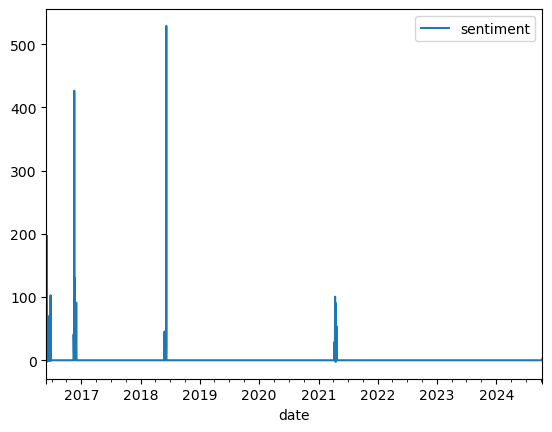

In [15]:
newSeries = series.resample('1d').sum()
# this plots and shows the time series
newSeries.plot()
plt.show()

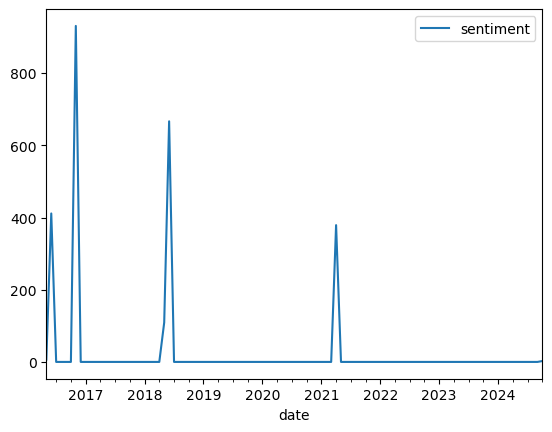

In [16]:
newSeries = series.resample('1ME').sum()
# this plots and shows the time series
newSeries.plot()
plt.show()

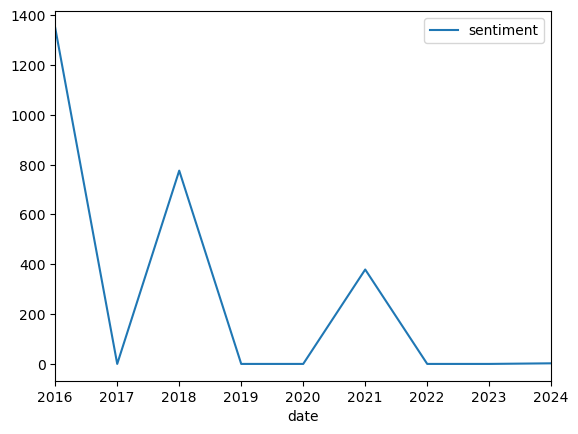

In [17]:
newSeries = series.resample('1YE').sum()
# this plots and shows the time series
newSeries.plot()
plt.show()

## Topic Modelling

In [18]:
lReviews = []
for reviews in youtube_df['content']:
    lTokens = processText(text=reviews, tokenizer=tweetTokeniser, lemmatizer=lemmatizer, stemmer=stemmer, stopwords=lStopwords,slang_dict=slang_dict)
    if len(lTokens) > 0:  # Add only non-empty tokenized reviews
        lReviews.append(lTokens)
    

Number of topics: 2, Coherence Score: 0.5896132246495305
Number of topics: 3, Coherence Score: 0.523421473656326
Number of topics: 4, Coherence Score: 0.49384134393733814
Number of topics: 5, Coherence Score: 0.4918109738429905
Number of topics: 6, Coherence Score: 0.4743706986817409
Number of topics: 7, Coherence Score: 0.5085269969623487
Number of topics: 8, Coherence Score: 0.4732321855552462
Number of topics: 9, Coherence Score: 0.503017822473243
Number of topics: 10, Coherence Score: 0.4605754182878316
Number of topics: 11, Coherence Score: 0.470663304577829
Number of topics: 12, Coherence Score: 0.4129718564918337
Number of topics: 13, Coherence Score: 0.4543429212728904
Number of topics: 14, Coherence Score: 0.4602200903004081
Number of topics: 15, Coherence Score: 0.455367672470806
Number of topics: 16, Coherence Score: 0.4600730641352948
Number of topics: 17, Coherence Score: 0.43451289065804155
Number of topics: 18, Coherence Score: 0.43966702155306403
Number of topics: 19, C

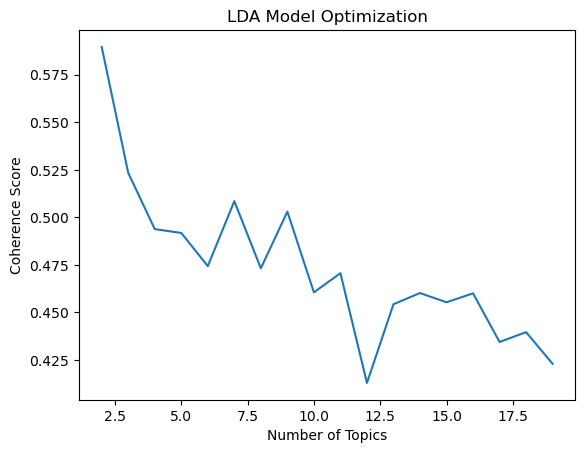

Best Number of Topics: 2
(0, '0.019*"get" + 0.017*"farm" + 0.014*"day" + 0.012*"one" + 0.011*"make" + 0.010*"work" + 0.009*"know" + 0.009*"need" + 0.008*"time" + 0.008*"year" + 0.008*"fish" + 0.008*"use" + 0.007*"good" + 0.007*"look" + 0.007*"also"')
(1, '0.032*"love" + 0.029*"like" + 0.018*"thank" + 0.014*"watch" + 0.013*"play" + 0.011*"give" + 0.011*"got" + 0.010*"laugh" + 0.009*"loud" + 0.008*"much" + 0.008*"pleas" + 0.008*"get" + 0.007*"gift" + 0.007*"best" + 0.007*"make"')


In [19]:
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(0)

# Assuming lReviews is your preprocessed tokenized reviews (list of lists of tokens)
# Create a dictionary and corpus
dictionary = corpora.Dictionary(lReviews)
corpus = [dictionary.doc2bow(review) for review in lReviews]

# Function to perform LDA with different parameter combinations and compute coherence
def lda_tuning(corpus, dictionary, texts, limit, start=2, step=1, passes=10, iterations=100, random_state=100):
    coherence_scores = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        # Train the LDA model
        model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics,
                                       random_state=random_state,
                                       passes=passes,
                                       iterations=iterations,
                                       alpha='auto',  # Can also optimize 'alpha'
                                       eta='auto')    # Can also optimize 'eta'
        
        # Calculate the coherence score
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherencemodel.get_coherence()
        coherence_scores.append(coherence_score)
        model_list.append(model)
        
        print(f'Number of topics: {num_topics}, Coherence Score: {coherence_score}')

    return model_list, coherence_scores

# Run the LDA optimization (tuning number of topics)
start = 2  # Min number of topics
limit = 20  # Max number of topics
step = 1  # Step size for topics
passes = 10  # Number of passes 
iterations = 100  # Number of iterations 

model_list, coherence_scores = lda_tuning(corpus=corpus, dictionary=dictionary, texts=lReviews, limit=limit, start=start, step=step, passes=passes, iterations=iterations)

# Plot the coherence scores to find the optimal number of topics
x = range(start, limit, step)
plt.plot(x, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("LDA Model Optimization")
plt.show()

# Select the model with the highest coherence score
best_num_topics = x[coherence_scores.index(max(coherence_scores))]
best_model = model_list[coherence_scores.index(max(coherence_scores))]

print(f'Best Number of Topics: {best_num_topics}')

# Display the topics of the best model
topics = best_model.show_topics(num_topics=best_num_topics, num_words=15)
for topic in topics:
    print(topic)


In [20]:
print(f"Number of documents in corpus: {len(corpus)}")
print(f"Number of unique tokens in dictionary: {len(dictionary)}")


Number of documents in corpus: 11768
Number of unique tokens in dictionary: 4410


In [21]:
print(coherence_scores)

[0.5896132246495305, 0.523421473656326, 0.49384134393733814, 0.4918109738429905, 0.4743706986817409, 0.5085269969623487, 0.4732321855552462, 0.503017822473243, 0.4605754182878316, 0.470663304577829, 0.4129718564918337, 0.4543429212728904, 0.4602200903004081, 0.455367672470806, 0.4600730641352948, 0.43451289065804155, 0.43966702155306403, 0.4230132778299207]


In [22]:
# For 3 topics
model_3 = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, passes=10, random_state=100)
topics_3 = model_3.show_topics(num_topics=3, num_words=10)
print("Topics for 3-Topic Model:")
for topic in topics_3:
    print(topic)
# For 7 topics
model_7 = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=7, passes=10, random_state=100)
topics_7 = model_7.show_topics(num_topics=7, num_words=10)
print("\nTopics for 7-Topic Model:")
for topic in topics_7:
    print(topic)


Topics for 3-Topic Model:
(0, '0.023*"farm" + 0.018*"get" + 0.013*"work" + 0.012*"like" + 0.012*"one" + 0.010*"make" + 0.010*"year" + 0.009*"need" + 0.009*"look" + 0.009*"realli"')
(1, '0.043*"love" + 0.028*"like" + 0.016*"give" + 0.016*"watch" + 0.013*"laugh" + 0.012*"loud" + 0.011*"heart" + 0.011*"gift" + 0.011*"get" + 0.010*"make"')
(2, '0.021*"day" + 0.021*"play" + 0.017*"thank" + 0.015*"much" + 0.015*"pig" + 0.012*"get" + 0.010*"hay" + 0.009*"barn" + 0.009*"eat" + 0.008*"sell"')

Topics for 7-Topic Model:
(0, '0.046*"like" + 0.032*"farm" + 0.028*"work" + 0.026*"realli" + 0.022*"look" + 0.019*"good" + 0.015*"nice" + 0.012*"still" + 0.012*"doe" + 0.010*"make"')
(1, '0.083*"love" + 0.032*"laugh" + 0.028*"loud" + 0.026*"pleas" + 0.026*"watch" + 0.021*"make" + 0.020*"like" + 0.018*"first" + 0.018*"great" + 0.014*"seri"')
(2, '0.076*"thank" + 0.049*"much" + 0.024*"love" + 0.022*"new" + 0.017*"time" + 0.016*"back" + 0.016*"help" + 0.014*"voic" + 0.011*"updat" + 0.010*"come"')
(3, '0.029*

In [23]:
lcontent = []

for content in youtube_df['content']:

    # tokenise, filter stopwords and get convert to lower case
    lTokens = processText(text=content, tokenizer=tweetTokeniser, lemmatizer=lemmatizer, stemmer=stemmer, stopwords=lStopwords,slang_dict=slang_dict)
    lcontent.append(' '.join(lTokens))

In [24]:
#
# Count Vectorizer
#
##
topicNum = best_num_topics
wordNumToDisplay = 15
featureNum = 1500

tfVectorizer = CountVectorizer(max_df=0.90, min_df=5, max_features=featureNum, stop_words='english')
tf = tfVectorizer.fit_transform(lcontent)
# extract the names of the features (in our case, the words)
tfFeatureNames = tfVectorizer.get_feature_names_out()

#
# LDA MODEL
#
ldaModel = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)

In [25]:
def display_topics(model, featureNames, numTopWords):
    """
    Prints out the most associated words for each feature.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    @param numTopWords: number of words to print per topic.
    """

    # print out the topic distributions
    for topicId, lTopicDist in enumerate(model.components_):
        print("Topic %d:" % (topicId))
        print(" ".join([featureNames[i] for i in lTopicDist.argsort()[:-numTopWords - 1:-1]]))

In [ ]:
#
# Count Vectorizer
#
##
topicNum = 3
wordNumToDisplay = 15
featureNum = 1500

tfVectorizer = CountVectorizer(max_df=0.90, min_df=5, max_features=featureNum, stop_words='english')
tf = tfVectorizer.fit_transform(lcontent)
# extract the names of the features (in our case, the words)
tfFeatureNames = tfVectorizer.get_feature_names_out()

#
# LDA MODEL
#
ldaModel3 = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)
display_topics(ldaModel3, tfFeatureNames, wordNumToDisplay)

In [ ]:
#
# Count Vectorizer
#
##
topicNum = 7
wordNumToDisplay = 15
featureNum = 1500

tfVectorizer = CountVectorizer(max_df=0.90, min_df=5, max_features=featureNum, stop_words='english')
tf = tfVectorizer.fit_transform(lcontent)
# extract the names of the features (in our case, the words)
tfFeatureNames = tfVectorizer.get_feature_names_out()

#
# LDA MODEL
#
ldaModel7 = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)
display_topics(ldaModel7, tfFeatureNames, wordNumToDisplay)

In [ ]:
def displayWordcloud(model, featureNames):
    """
    Displays the word cloud of the topic distributions, stored in model.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    """
    normalisedComponents = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    
    topicNum = len(model.components_)
    # number of wordclouds for each row
    plotColNum = 3
    # number of wordclouds for each column
    plotRowNum = int(math.ceil(topicNum / plotColNum))

    for topicId, lTopicDist in enumerate(normalisedComponents):
        lWordProb = {featureNames[i] : wordProb for i,wordProb in enumerate(lTopicDist)}
        wordcloud = WordCloud(background_color='black')
        wordcloud.fit_words(frequencies=lWordProb)
        plt.subplot(plotRowNum, plotColNum, topicId+1)
        plt.title('Topic %d:' % (topicId+1))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")

    plt.show(block=True)

In [ ]:
displayWordcloud(ldaModel, tfFeatureNames)

In [ ]:
displayWordcloud(ldaModel7, tfFeatureNames)

In [ ]:
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)